# HERMES Extended 3D MetModel Analysis

**Features implemented:**
1. Toggle intrinsic scatter (free / fixed / off)
2. Iterate over multiple MCMC seeds to probe diversity
3. Toggle log-space vs linear-space
4. Two independent leverages: $L_{\mathrm{mass}}$ and $L_{\mathrm{stellar}}$
5. Z-scores per parameter per survey (vs oracle fit)
6. WAIC model comparison (full vs no-scatter vs no-stellar)
7. Hierarchical MetModel extension with weakly informative hyperpriors
8. All plots match HERMES `plots.py` style

In [2]:
# !pip install -q numpyro jax jaxlib arviz

In [3]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import log_likelihood
import arviz as az
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Optional, Literal, Tuple
import warnings
warnings.filterwarnings('ignore')

numpyro.set_platform('cpu')
numpyro.set_host_device_count(1)
print('JAX devices:', jax.devices())

JAX devices: [CpuDevice(id=0)]


## 1. Load Data
Upload `hermes_synthetic_data_0.2.0.csv`.

## 2. Configuration
Edit these toggles to control the experiment.

In [4]:
# ==================== USER CONFIGURATION ====================

# MCMC seeds to iterate over (more seeds = better diversity estimate)
MCMC_SEEDS = [321, 42, 123, 999, 2024]

# Survey design
SURVEY_SEED = 42          # fixed seed for survey sampling
N_GRID = [30, 50, 100]    # sample sizes
N_REPS = 10                # surveys per (class, N) combination

# MCMC settings (keep low for Colab speed; increase for production)
DRAWS = 500
TUNE = 500
TARGET_ACCEPT = 0.9
NUM_CHAINS = 1

# Toggle: intrinsic scatter  ('free', 'fixed', 'off')
SCATTER_MODE = 'free'
SCATTER_FIXED_VALUE = 0.3   # only used when SCATTER_MODE='fixed'

# Toggle: log space
# True  -> model log(X_H2O) directly  (default, same as HERMES)
# False -> model X_H2O = 10^log(X_H2O) in linear space
USE_LOG_SPACE = True

# Ground truth for z-scores (None = oracle fit on full catalog)
GROUND_TRUTH = None  # or {'alpha_p': ..., 'beta_p': ..., 'beta_s': ..., 'epsilon': ...}

# WAIC
COMPUTE_WAIC = True

n_surveys = len(N_GRID) * 4 * N_REPS
n_models = 3 + (1 if SCATTER_MODE == 'fixed' else 0)
print(f'Surveys: {n_surveys}')
print(f'Models: {n_models} variants x {len(MCMC_SEEDS)} seeds')
print(f'Total fits: {n_surveys * n_models * len(MCMC_SEEDS)}')

Surveys: 120
Models: 3 variants x 5 seeds
Total fits: 1800


## 3. Survey Infrastructure
Copied from HERMES `Survey.py` (unchanged logic).

In [5]:
class Survey:
    def __init__(self, survey_id, class_label, df):
        self.survey_id = int(survey_id)
        self.class_label = str(class_label)
        self.df = df.reset_index(drop=True)

    @property
    def n(self):
        return len(self.df)

    def leverage(self, col='logM'):
        '''L = sqrt(sum_i (x_i - mean(x))^2), same as HERMES.'''
        arr = self.df[col].to_numpy(float)
        m = np.isfinite(arr)
        arr = arr[m]
        if arr.size < 2:
            return 0.0
        return float(np.sqrt(np.sum((arr - arr.mean()) ** 2)))


class SurveySampler:
    def __init__(self, raw_df, rng_seed=None):
        self.raw_df = raw_df
        self.rng = np.random.default_rng(rng_seed)
        self.mass_classes = self._build_mass_classes()

    def _build_mass_classes(self):
        df = self.raw_df
        q25, q50, q75 = df['logM'].quantile([0.25, 0.5, 0.75])
        return {
            'S1': df.copy(),
            'S2': df[df['logM'] >= q25].copy(),
            'S3': df[df['logM'] >= q50].copy(),
            'S4': df[df['logM'] >= q75].copy(),
        }

    def sample_grid(self, N_grid, n_reps_per_combo=10, class_order=None):
        if class_order is None:
            class_order = ['S1', 'S2', 'S3', 'S4']
        surveys = []
        sid = 1
        for label in class_order:
            if label not in self.mass_classes:
                continue
            subset = self.mass_classes[label]
            for N in N_grid:
                if N > len(subset):
                    continue
                for _ in range(n_reps_per_combo):
                    rs = int(self.rng.integers(0, 2**32 - 1))
                    sdf = subset.sample(n=N, replace=False, random_state=rs)
                    surveys.append(Survey(sid, label, sdf))
                    sid += 1
        return surveys

print('Survey infrastructure ready.')

Survey infrastructure ready.


## 4. Model Definitions
Three model variants for comparison, plus an optional fixed-scatter model.

| Model | Equation | Purpose |
|---|---|---|
| **B\_full** | $y = \alpha_p + \beta_p m_c + \beta_s s_c + \varepsilon$ | Current HERMES (free scatter) |
| **A\_no\_scatter** | $y = \alpha_p + \beta_p m_c + \beta_s s_c$ | Is scatter needed? |
| **C\_no\_stellar** | $y = \alpha_p + \beta_p m_c + \varepsilon$ | Is stellar met needed? |
| **D\_fixed\_scatter** | Same as B but $\varepsilon$ fixed | Prior sensitivity |

In [6]:
# ---- Model B: Full MetModel (free scatter + stellar) ----
def met_model_full(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
                   alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
                   epsilon_p_sigma):
    x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))
    x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)
    alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
    beta_s  = numpyro.sample('beta_s',  dist.Normal(1.0, beta_s_sigma))
    epsilon = numpyro.sample('epsilon',  dist.HalfNormal(epsilon_p_sigma))
    mu = alpha_p[..., None] + beta_p[..., None] * x_m_c + beta_s[..., None] * x_s_true_c
    obs_sigma = jnp.sqrt(sig_meas_p**2 + epsilon[..., None]**2)
    numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)


# ---- Model A: No scatter (epsilon = 0) ----
def met_model_no_scatter(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
                          alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
                          epsilon_p_sigma):
    x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))
    x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)
    alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
    beta_s  = numpyro.sample('beta_s',  dist.Normal(1.0, beta_s_sigma))
    numpyro.deterministic('epsilon', jnp.zeros(()))
    mu = alpha_p[..., None] + beta_p[..., None] * x_m_c + beta_s[..., None] * x_s_true_c
    numpyro.sample('y_planet', dist.Normal(mu, sig_meas_p), obs=y_planet)


# ---- Model C: No stellar term (mass + scatter only) ----
def met_model_no_stellar(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
                          alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
                          epsilon_p_sigma):
    alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
    numpyro.deterministic('beta_s', jnp.zeros(()))
    epsilon = numpyro.sample('epsilon', dist.HalfNormal(epsilon_p_sigma))
    mu = alpha_p[..., None] + beta_p[..., None] * x_m_c
    obs_sigma = jnp.sqrt(sig_meas_p**2 + epsilon[..., None]**2)
    numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)


# ---- Model D: Fixed scatter (epsilon = constant) ----
def make_met_model_fixed_scatter(fixed_value):
    fv = float(fixed_value)
    def model(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
              alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
              epsilon_p_sigma):
        x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))
        x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)
        alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
        beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
        beta_s  = numpyro.sample('beta_s',  dist.Normal(1.0, beta_s_sigma))
        numpyro.deterministic('epsilon', jnp.array(fv))
        mu = alpha_p[..., None] + beta_p[..., None] * x_m_c + beta_s[..., None] * x_s_true_c
        obs_sigma = jnp.sqrt(sig_meas_p**2 + fv**2)
        numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)
    return model

print('Model definitions ready.')

Model definitions ready.


## 5. Fitting Infrastructure

In [7]:
def prepare_model_kwargs(df_in, use_log_space=True):
    '''Build the dict of JAX arrays that every model variant accepts.'''
    x_m = df_in['logM'].to_numpy(float)
    x_s_obs = df_in['Star Metallicity'].to_numpy(float)

    if use_log_space:
        yp = df_in['log(X_H2O)'].to_numpy(float)
    else:
        yp = 10.0 ** df_in['log(X_H2O)'].to_numpy(float)

    el_p = df_in['uncertainty_lower'].to_numpy(float)
    eh_p = df_in['uncertainty_upper'].to_numpy(float)
    el_s = df_in['Star Metallicity Error Lower'].to_numpy(float)
    eh_s = df_in['Star Metallicity Error Upper'].to_numpy(float)

    sig_p = np.clip(0.5 * (np.abs(el_p) + np.abs(eh_p)), 1e-6, None)
    sig_s = np.clip(0.5 * (np.abs(el_s) + np.abs(eh_s)), 1e-6, None)

    if not use_log_space:
        sig_p = np.abs(yp) * sig_p * np.log(10)

    m = (np.isfinite(x_m) & np.isfinite(x_s_obs) & np.isfinite(yp)
         & np.isfinite(sig_p) & np.isfinite(sig_s))
    x_m, x_s_obs, yp, sig_p, sig_s = x_m[m], x_s_obs[m], yp[m], sig_p[m], sig_s[m]

    x_m_c = x_m - float(x_m.mean())

    span_xm = max(float(np.ptp(x_m_c)), 1e-3)
    span_xs = max(float(np.ptp(x_s_obs - x_s_obs.mean())), 1e-3)
    span_yp = max(float(np.ptp(yp)), 1e-3)
    yp_sd = max(float(np.std(yp, ddof=1)) if len(yp) > 1 else 1.0, 1e-3)

    return dict(
        x_m_c       = jnp.array(x_m_c,   dtype=jnp.float32),
        x_s_obs     = jnp.array(x_s_obs,  dtype=jnp.float32),
        sig_meas_p  = jnp.array(sig_p,    dtype=jnp.float32),
        sig_meas_s  = jnp.array(sig_s,    dtype=jnp.float32),
        y_planet    = jnp.array(yp,       dtype=jnp.float32),
        alpha_p_mu     = float(yp.mean()),
        alpha_p_sigma  = max(float(yp_sd / np.sqrt(len(yp))), 1e-3),
        beta_p_sigma   = max(float(span_yp / span_xm), 1e-3),
        beta_s_sigma   = max(float(span_yp / span_xs), 1e-3),
        epsilon_p_sigma = max(float(yp_sd), 1e-3),
    )


def fit_model(model_fn, mkw, seed, draws, tune, ta, nchains=1, do_ll=False):
    rng_key = jax.random.PRNGKey(int(seed))
    kernel = NUTS(model_fn, target_accept_prob=float(ta))
    mcmc = MCMC(kernel, num_warmup=int(tune), num_samples=int(draws),
                num_chains=int(nchains), progress_bar=False)
    mcmc.run(rng_key, **mkw)
    if do_ll:
        post = mcmc.get_samples(group_by_chain=True)
        ll = log_likelihood(model_fn, post, **mkw)
        return az.from_numpyro(mcmc, log_likelihood=ll)
    return az.from_numpyro(mcmc)


def extract_summary(idata):
    row = {}
    for param in ['alpha_p', 'beta_p', 'beta_s', 'epsilon']:
        if param in idata.posterior:
            s = np.asarray(idata.posterior[param]).reshape(-1)
            row[f'{param}_mean'] = float(s.mean())
            row[f'{param}_sd']   = float(s.std(ddof=1)) if s.size > 1 else 0.0
            lo, hi = np.quantile(s, [0.16, 0.84])
            row[f'{param}_hdi16'] = float(lo)
            row[f'{param}_hdi84'] = float(hi)
    return row

print('Fitting infrastructure ready.')

Fitting infrastructure ready.


In [8]:
raw_df = pd.read_csv('hermes_synthetic_data_0.2.0.csv')

## 6. Run Experiments
Build surveys once, then fit every (model, seed) combination.

In [9]:
# Build surveys ONCE
sampler = SurveySampler(raw_df, rng_seed=SURVEY_SEED)
surveys = sampler.sample_grid(N_GRID, n_reps_per_combo=N_REPS)
print(f'Built {len(surveys)} surveys')

# Model variants
MODEL_VARIANTS = [
    (met_model_full,       'B_full'),
    (met_model_no_scatter, 'A_no_scatter'),
    (met_model_no_stellar, 'C_no_stellar'),
]
if SCATTER_MODE == 'fixed':
    MODEL_VARIANTS.append(
        (make_met_model_fixed_scatter(SCATTER_FIXED_VALUE), 'D_fixed_scatter')
    )

PRIMARY = {'free': 'B_full', 'off': 'A_no_scatter', 'fixed': 'D_fixed_scatter'}[SCATTER_MODE]

# Run
all_rows = []
total = len(surveys) * len(MODEL_VARIANTS) * len(MCMC_SEEDS)
count = 0

for model_fn, mname in MODEL_VARIANTS:
    print(f'\n--- {mname} ---')
    for mseed in MCMC_SEEDS:
        rng = np.random.default_rng(mseed)
        for survey in surveys:
            count += 1
            if count % 30 == 0 or count == total:
                print(f'  [{count}/{total}]', flush=True)
            rs = int(rng.integers(0, 2**32 - 1))
            mkw = prepare_model_kwargs(survey.df, use_log_space=USE_LOG_SPACE)
            idata = fit_model(model_fn, mkw, rs,
                              draws=DRAWS, tune=TUNE, ta=TARGET_ACCEPT,
                              nchains=NUM_CHAINS, do_ll=COMPUTE_WAIC)
            row = extract_summary(idata)
            row['model']       = mname
            row['seed']        = mseed
            row['survey_id']   = survey.survey_id
            row['class_label'] = survey.class_label
            row['N']           = survey.n
            row['L_mass']      = survey.leverage('logM')
            row['L_stellar']   = survey.leverage('Star Metallicity')

            if COMPUTE_WAIC:
                try:
                    w = az.waic(idata)
                    row['waic']    = float(w.elpd_waic)
                    row['waic_se'] = float(w.se)
                except Exception:
                    row['waic']    = np.nan
                    row['waic_se'] = np.nan

            all_rows.append(row)

df_results = pd.DataFrame(all_rows)
print(f'\nDone! {len(df_results)} rows.')
df_results.to_csv('hermes_extended_results.csv', index=False)
print('Saved hermes_extended_results.csv')

Built 120 surveys

--- B_full ---
  [30/1800]
  [60/1800]
  [90/1800]
  [120/1800]
  [150/1800]
  [180/1800]
  [210/1800]
  [240/1800]
  [270/1800]
  [300/1800]
  [330/1800]
  [360/1800]
  [390/1800]
  [420/1800]
  [450/1800]
  [480/1800]
  [510/1800]
  [540/1800]
  [570/1800]
  [600/1800]

--- A_no_scatter ---
  [630/1800]
  [660/1800]
  [690/1800]
  [720/1800]
  [750/1800]
  [780/1800]
  [810/1800]
  [840/1800]
  [870/1800]
  [900/1800]
  [930/1800]
  [960/1800]
  [990/1800]
  [1020/1800]
  [1050/1800]
  [1080/1800]
  [1110/1800]
  [1140/1800]
  [1170/1800]
  [1200/1800]

--- C_no_stellar ---
  [1230/1800]
  [1260/1800]
  [1290/1800]
  [1320/1800]
  [1350/1800]
  [1380/1800]
  [1410/1800]
  [1440/1800]
  [1470/1800]
  [1500/1800]
  [1530/1800]
  [1560/1800]
  [1590/1800]
  [1620/1800]
  [1650/1800]
  [1680/1800]
  [1710/1800]
  [1740/1800]
  [1770/1800]
  [1800/1800]

Done! 1800 rows.
Saved hermes_extended_results.csv


## 7. Oracle Fit & Z-Scores

Z-score: $z_\theta^{(k)} = \frac{\hat\theta^{(k)} - \theta_{\rm ref}}{\sigma_\theta^{(k)}}$

If the model is well-calibrated, z-scores across surveys should be ~ $\mathcal{N}(0,1)$.

In [10]:
if GROUND_TRUTH is None:
    print('Fitting oracle on full catalog ...')
    oracle_mkw = prepare_model_kwargs(raw_df, use_log_space=USE_LOG_SPACE)
    oracle_idata = fit_model(met_model_full, oracle_mkw, seed=0,
                             draws=DRAWS*2, tune=TUNE*2, ta=TARGET_ACCEPT,
                             nchains=NUM_CHAINS, do_ll=False)
    REFERENCE = {}
    for p in ['alpha_p', 'beta_p', 'beta_s', 'epsilon']:
        REFERENCE[p] = float(np.asarray(oracle_idata.posterior[p]).mean())
    print('Oracle reference:', REFERENCE)
else:
    REFERENCE = GROUND_TRUTH
    print('Using provided ground truth:', REFERENCE)

for p in ['alpha_p', 'beta_p', 'beta_s', 'epsilon']:
    mc = f'{p}_mean'
    sc = f'{p}_sd'
    if mc in df_results.columns and sc in df_results.columns:
        df_results[f'z_{p}'] = (
            (df_results[mc] - REFERENCE[p]) / df_results[sc].clip(lower=1e-10)
        )

print('\nZ-score summary (primary model, first seed):')
mask = (df_results['model'] == PRIMARY) & (df_results['seed'] == MCMC_SEEDS[0])
z_cols = [c for c in df_results.columns if c.startswith('z_')]
display(df_results.loc[mask, z_cols].describe().round(3))

Fitting oracle on full catalog ...


Oracle reference: {'alpha_p': -0.31584447622299194, 'beta_p': -1.1346896886825562, 'beta_s': 0.058254044502973557, 'epsilon': 0.4939000904560089}

Z-score summary (primary model, first seed):


,z_alpha_p,z_beta_p,z_beta_s,z_epsilon
count,120.000,120.000,120.000,120.000
mean,-11.464,0.445,0.314,-0.053
std,9.705,0.988,0.975,0.877
min,-33.616,-1.925,-2.662,-2.351
25%,-18.427,-0.209,-0.341,-0.717
50%,-10.503,0.440,0.413,-0.008
75%,-3.311,1.170,0.843,0.566
max,5.393,2.742,3.024,1.836


## 8. WAIC Model Comparison

$\Delta$WAIC$_{\rm scatter}$ = elpd(full) $-$ elpd(no scatter) $\rightarrow$ positive = scatter helps

$\Delta$WAIC$_{\rm stellar}$ = elpd(full) $-$ elpd(no stellar) $\rightarrow$ positive = stellar met helps

In [11]:
waic_wide = None
if COMPUTE_WAIC and 'waic' in df_results.columns:
    piv = df_results.pivot_table(
        index=['survey_id', 'seed', 'class_label', 'N', 'L_mass', 'L_stellar'],
        columns='model', values='waic',
    ).reset_index()

    waic_wide = piv.copy()
    if 'B_full' in piv.columns and 'A_no_scatter' in piv.columns:
        waic_wide['delta_waic_scatter'] = piv['B_full'] - piv['A_no_scatter']
    if 'B_full' in piv.columns and 'C_no_stellar' in piv.columns:
        waic_wide['delta_waic_stellar'] = piv['B_full'] - piv['C_no_stellar']

    for col in ['delta_waic_scatter', 'delta_waic_stellar']:
        if col in waic_wide.columns:
            v = waic_wide[col].dropna()
            print(f'{col}: mean={v.mean():.3f}  median={v.median():.3f}  frac>0={((v>0).mean()):.1%}')
else:
    print('WAIC not available.')

delta_waic_scatter: mean=69.189  median=49.191  frac>0=97.8%
delta_waic_stellar: mean=-0.391  median=-0.678  frac>0=19.0%


## 9. Results Summary

In [12]:
df_prim = df_results[df_results['model'] == PRIMARY].copy()
print(f'Primary model: {PRIMARY}')
print(f'\nSurveys per (class, N):')
display(df_prim.groupby(['class_label', 'N']).size().unstack(fill_value=0))

sd_cols = [c for c in ['alpha_p_sd','beta_p_sd','beta_s_sd','epsilon_sd'] if c in df_prim.columns]
print('\nMean posterior SD by class:')
display(df_prim.groupby('class_label')[sd_cols].mean().round(4))

Primary model: B_full

Surveys per (class, N):


N,30,50,100
class_label,,,
S1,50,50,50
S2,50,50,50
S3,50,50,50
S4,50,50,50



Mean posterior SD by class:


,alpha_p_sd,beta_p_sd,beta_s_sd,epsilon_sd
class_label,,,,
S1,0.0694,0.0981,0.4431,0.0634
S2,0.0660,0.1497,0.4807,0.0650
S3,0.0572,0.2419,0.4755,0.0613
S4,0.0526,0.2562,0.4815,0.0581


## 10. Plots
All plots use the HERMES `plots.py` style.

In [13]:
# ---- HERMES plot style ----
plt.rcParams.update({
    'figure.dpi': 130, 'savefig.dpi': 300, 'font.size': 11,
    'axes.titlesize': 12, 'axes.labelsize': 11,
    'axes.spines.top': False, 'axes.spines.right': False,
    'axes.linewidth': 1.0,
    'xtick.direction': 'out', 'ytick.direction': 'out',
    'xtick.major.size': 4,   'ytick.major.size': 4,
})

CLS_ORD = ['S1', 'S2', 'S3', 'S4']
CLS_CLR = {'S1': 'C0', 'S2': 'C1', 'S3': 'C2', 'S4': 'C3'}


def _pl_fit(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    lx, ly = np.log(x[m]), np.log(y[m])
    A = np.vstack([np.ones_like(lx), lx]).T
    b = np.linalg.lstsq(A, ly, rcond=None)[0]
    return float(np.exp(b[0])), float(b[1])


def _pl_band(x, y, xg, z=1.0):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    lx, ly = np.log(x[m]), np.log(y[m])
    A = np.vstack([np.ones_like(lx), lx]).T
    b, *_ = np.linalg.lstsq(A, ly, rcond=None)
    lxg = np.log(np.asarray(xg, float))
    mu = b[0] + b[1] * lxg
    r = ly - (A @ b)
    dof = max(len(ly) - 2, 1)
    s2 = float(np.dot(r, r) / dof)
    Ai = np.linalg.inv(A.T @ A)
    Ag = np.vstack([np.ones_like(lxg), lxg]).T
    v = np.einsum('ij,jk,ik->i', Ag, Ai, Ag) * s2
    se = np.sqrt(np.maximum(v, 0.0))
    return np.exp(mu), np.exp(mu - z * se), np.exp(mu + z * se)


def _lin_fit(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    X = np.vstack([np.ones_like(x[m]), x[m]]).T
    return np.linalg.lstsq(X, y[m], rcond=None)[0]


def scatter_fits(ax, x, y, labels, ylabel_tex, xlabel_tex):
    '''Scatter by class + power-law + linear overlays (HERMES style).'''
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    for cls in CLS_ORD:
        cm = (labels == cls)
        if not cm.any():
            continue
        ax.scatter(x[cm], y[cm], s=18, alpha=0.9, color=CLS_CLR.get(cls, 'k'), label=cls)
    ax.set_xlabel(xlabel_tex)
    ax.set_ylabel(ylabel_tex)
    ax.minorticks_on()
    xf, yf = x[m], y[m]
    if xf.size < 2:
        return
    xg = np.linspace(xf.min() * 0.98, xf.max() * 1.02, 200)
    yh, lo, hi = _pl_band(xf, yf, xg)
    ax.fill_between(xg, lo, hi, alpha=0.15, linewidth=0)
    ax.plot(xg, yh, ls='--', lw=1.2)
    a, b = _pl_fit(xf, yf)
    xr, yr = ax.get_xlim(), ax.get_ylim()
    ann = ylabel_tex + r' $\propto L^{' + f'{b:.2f}' + r'}$'
    ax.text(xr[0] + 0.55*(xr[1]-xr[0]), yr[0] + 0.86*(yr[1]-yr[0]), ann, fontsize=8)


def add_legend(ax, sub):
    hs, ls = [], []
    for cls in CLS_ORD:
        if (sub['class_label'] == cls).any():
            hs.append(plt.Line2D([], [], ls='none', marker='o', ms=5, color=CLS_CLR.get(cls,'k')))
            ls.append(cls)
    if hs:
        ax.legend(hs, ls, title='class', fontsize=8, title_fontsize=9, frameon=False, loc='best')

print('Plot utilities ready.')

Plot utilities ready.


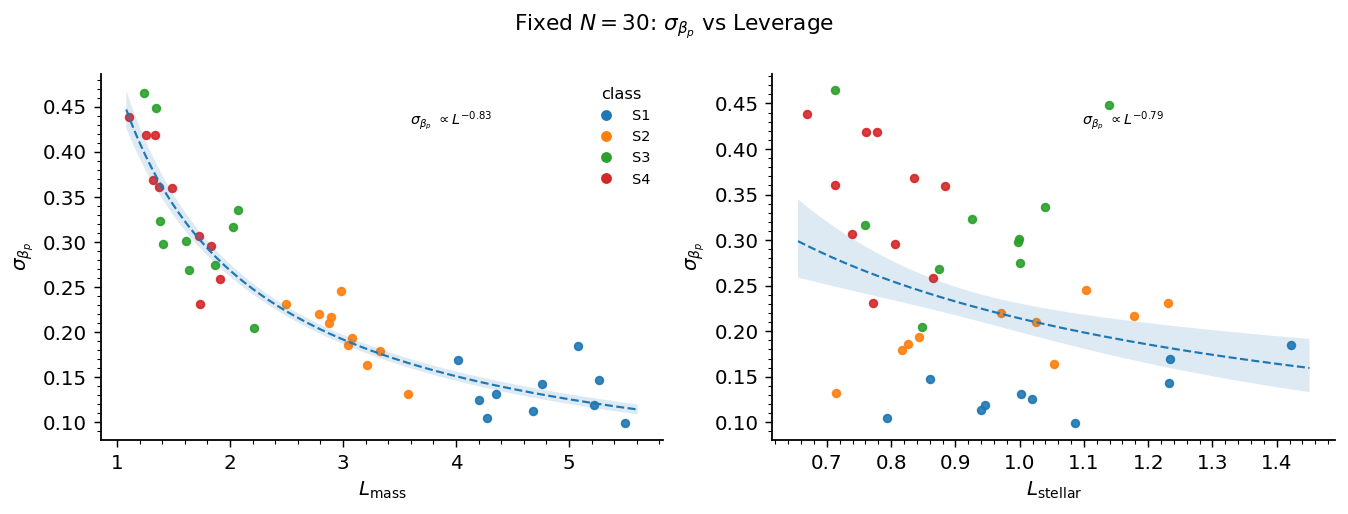

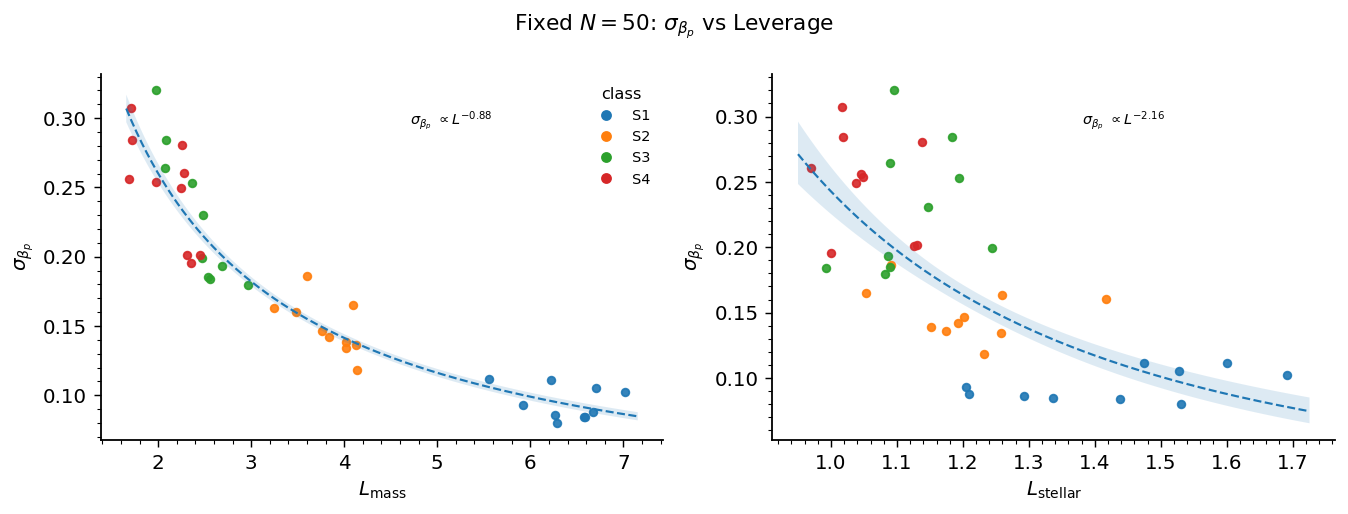

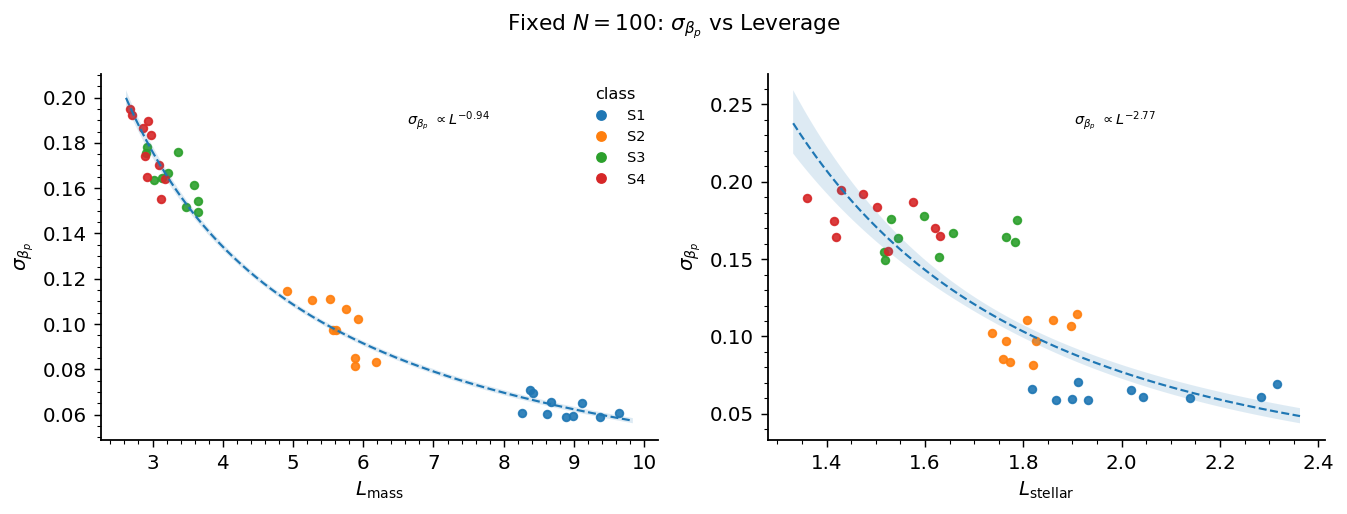

In [14]:
# sigma(beta_p) vs L_mass AND L_stellar  (fixed-N panels)
df_pl = df_results[(df_results['model'] == PRIMARY) &
                   (df_results['seed'] == MCMC_SEEDS[0])].copy()

for N0 in sorted(df_pl['N'].unique()):
    sub = df_pl[df_pl['N'] == N0]
    if len(sub) < 3:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
    fig.suptitle(rf'Fixed $N={N0}$: $\sigma_{{\beta_p}}$ vs Leverage', fontsize=12)
    labels = sub['class_label'].to_numpy(str)
    scatter_fits(axes[0], sub['L_mass'].values, sub['beta_p_sd'].values,
                 labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{mass}}$')
    scatter_fits(axes[1], sub['L_stellar'].values, sub['beta_p_sd'].values,
                 labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{stellar}}$')
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.savefig(f'hermes_extended_beta_p_sd_vs_leverage_N{N0}.png')
    plt.show()

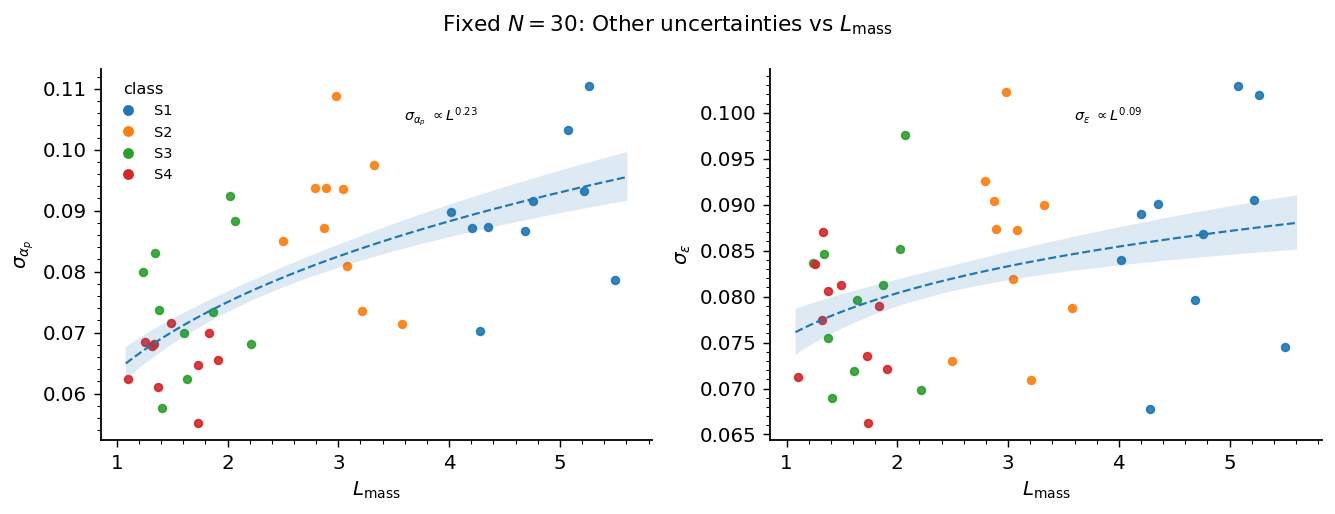

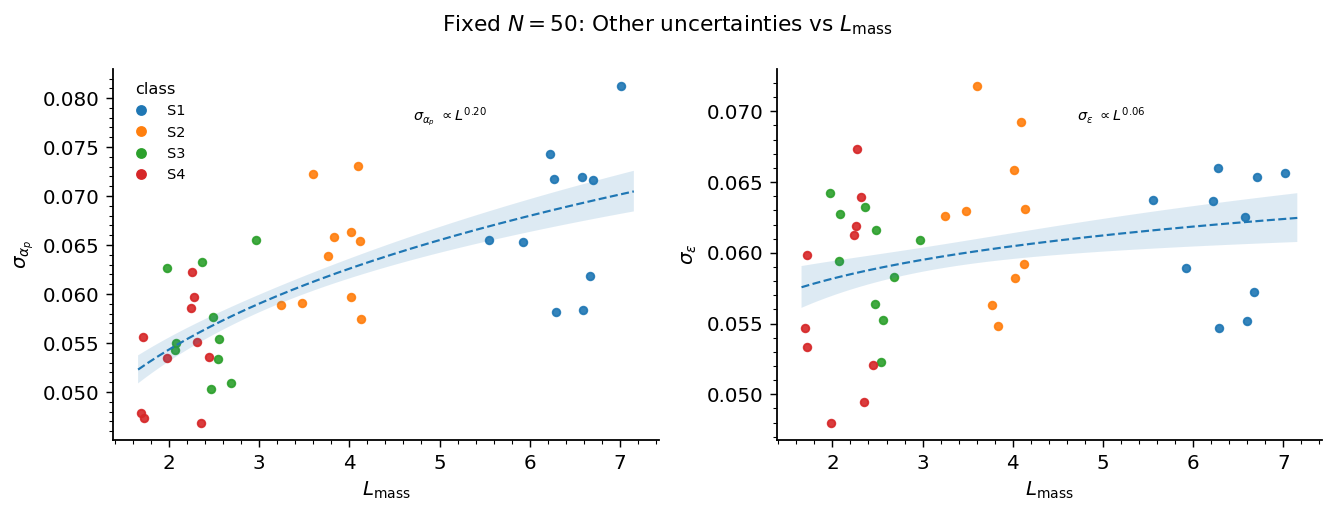

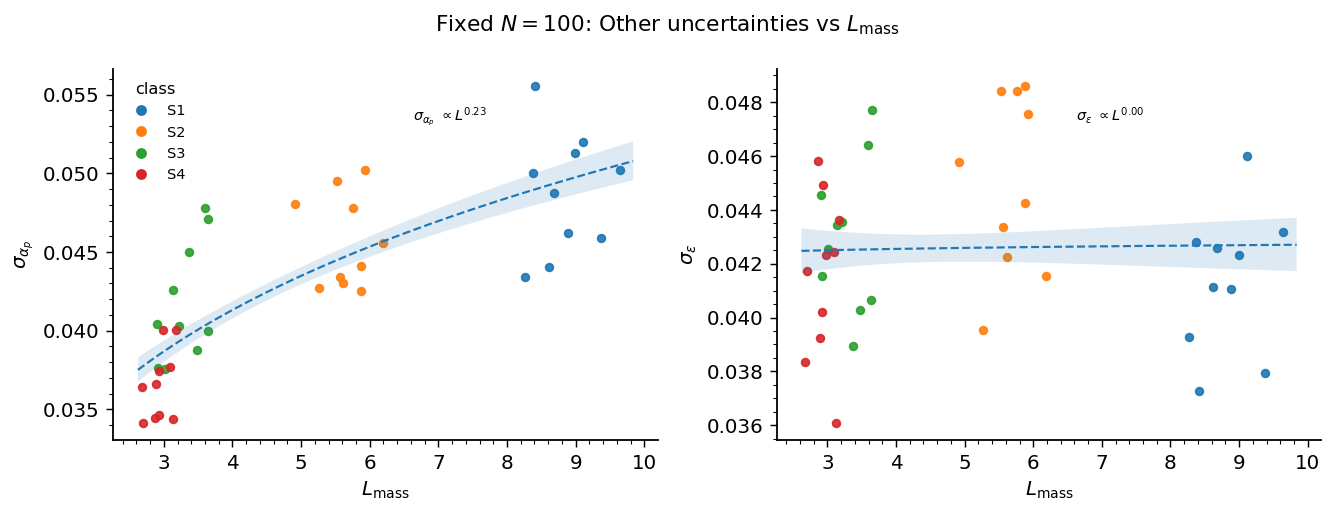

In [15]:
# sigma(alpha_p) and sigma(epsilon) vs L_mass  (fixed-N panels)
for N0 in sorted(df_pl['N'].unique()):
    sub = df_pl[df_pl['N'] == N0]
    if len(sub) < 3:
        continue
    panels = []
    if 'alpha_p_sd' in sub.columns:
        panels.append(('alpha_p_sd', r'$\sigma_{\alpha_p}$'))
    if 'epsilon_sd' in sub.columns:
        panels.append(('epsilon_sd', r'$\sigma_{\varepsilon}$'))
    if not panels:
        continue
    fig, axes = plt.subplots(1, len(panels), figsize=(5.2*len(panels), 4))
    if len(panels) == 1:
        axes = [axes]
    fig.suptitle(rf'Fixed $N={N0}$: Other uncertainties vs $L_{{\mathrm{{mass}}}}$', fontsize=12)
    labels = sub['class_label'].to_numpy(str)
    for ax, (col, ylabel) in zip(axes, panels):
        scatter_fits(ax, sub['L_mass'].values, sub[col].values,
                     labels, ylabel, r'$L_{\mathrm{mass}}$')
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.savefig(f'hermes_extended_{PRIMARY}_N{N0}_leverage.pdf')
    plt.show()

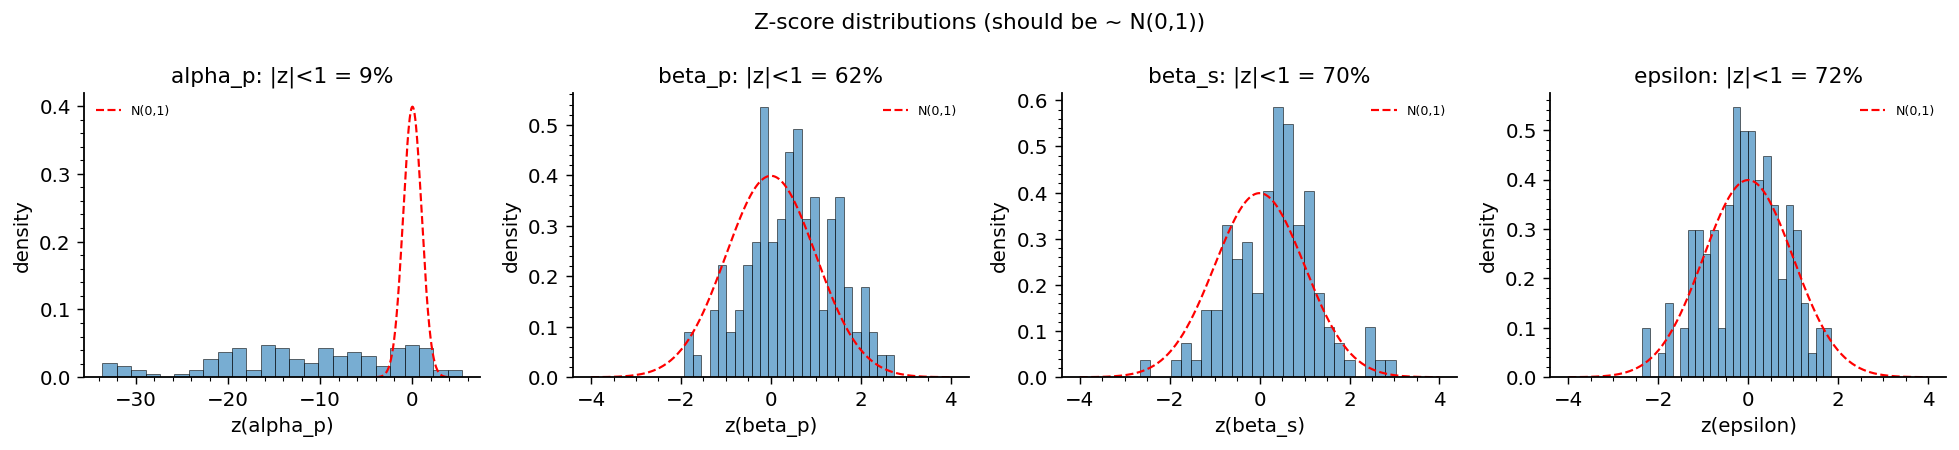

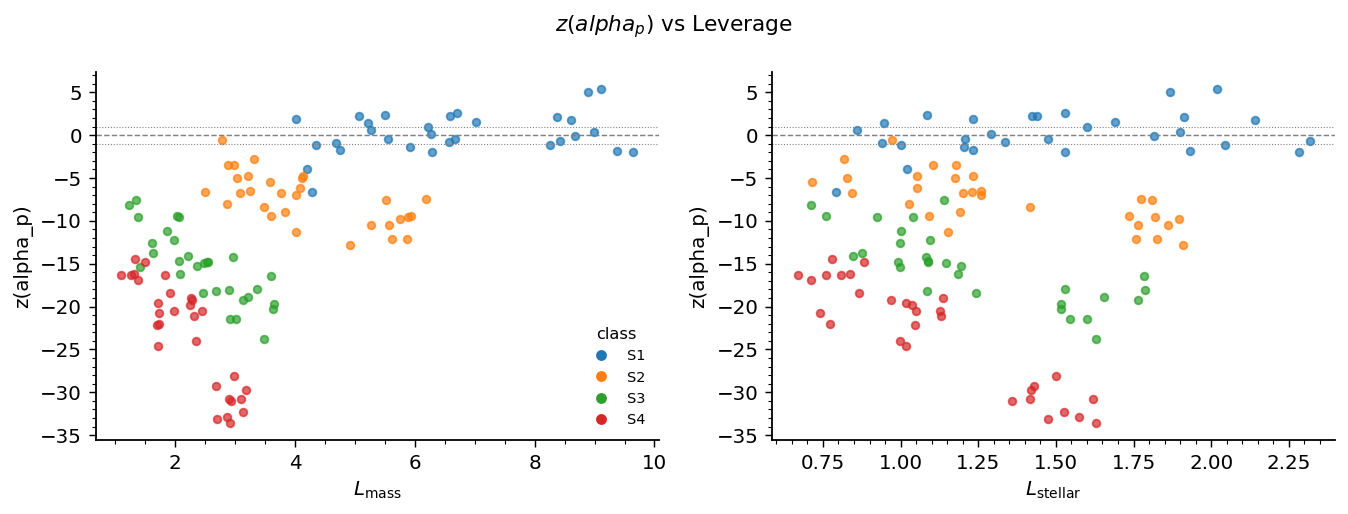

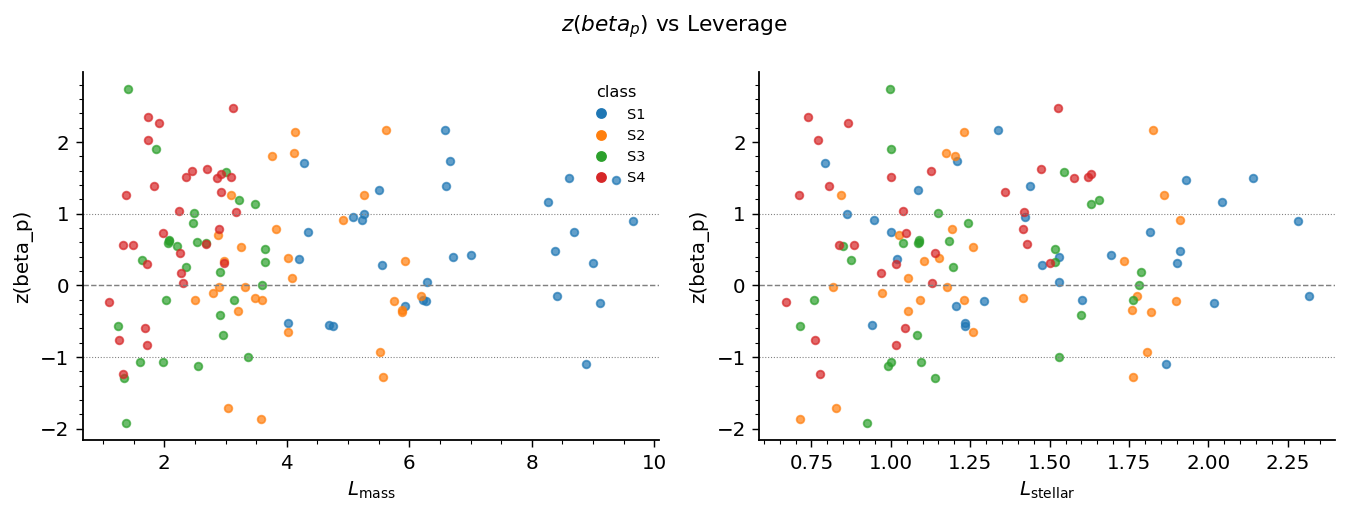

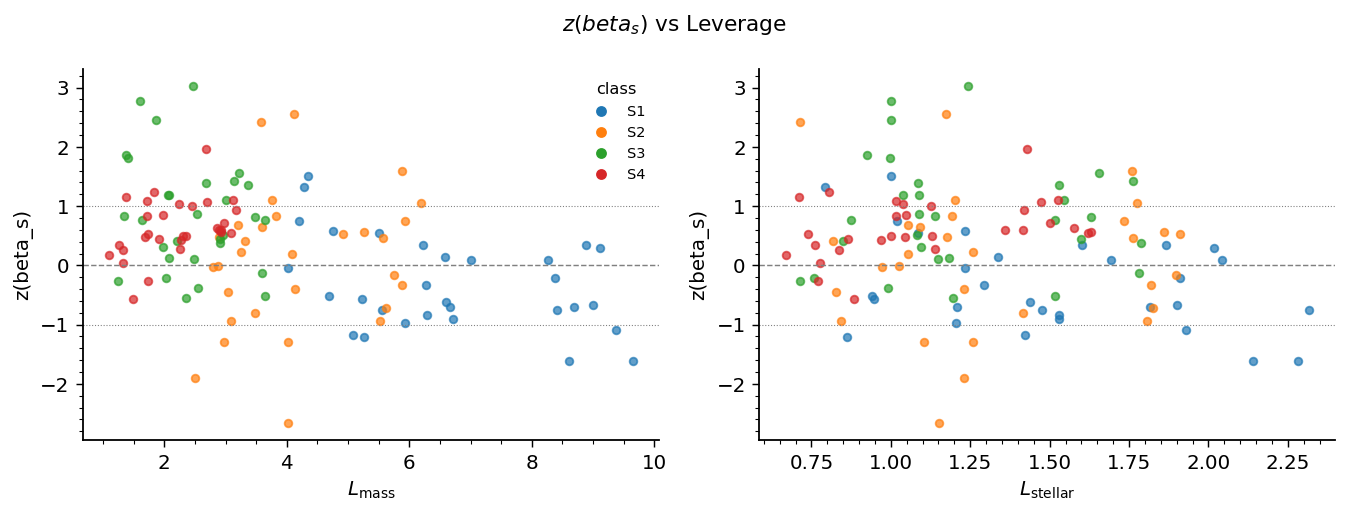

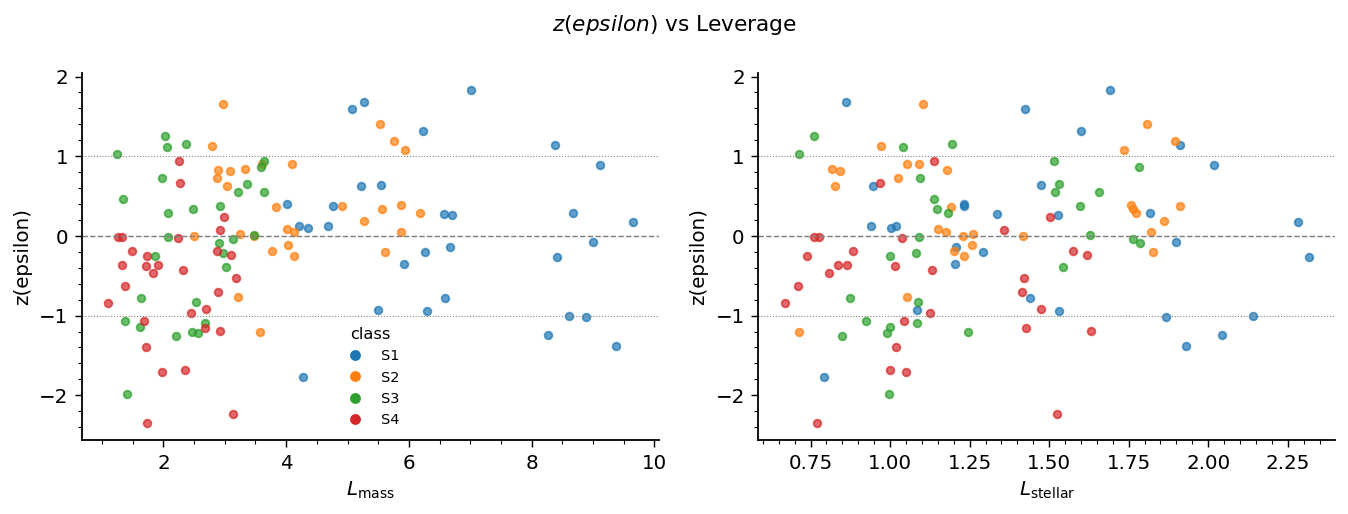

In [16]:
# Z-score histograms and Z vs leverage
df_z = df_results[(df_results['model'] == PRIMARY) &
                  (df_results['seed'] == MCMC_SEEDS[0])].copy()
z_params = [p for p in ['alpha_p','beta_p','beta_s','epsilon'] if f'z_{p}' in df_z.columns]

# --- Histograms ---
n_par = len(z_params)
fig, axes = plt.subplots(1, n_par, figsize=(3.8*n_par, 3.5))
if n_par == 1:
    axes = [axes]
fig.suptitle('Z-score distributions (should be ~ N(0,1))', fontsize=12)
xgrid = np.linspace(-4, 4, 200)
gauss = np.exp(-0.5*xgrid**2) / np.sqrt(2*np.pi)
for ax, p in zip(axes, z_params):
    vals = df_z[f'z_{p}'].dropna()
    ax.hist(vals, bins=25, density=True, alpha=0.6, edgecolor='k', lw=0.5)
    ax.plot(xgrid, gauss, 'r--', lw=1.2, label='N(0,1)')
    ax.set_xlabel(f'z({p})')
    ax.set_ylabel('density')
    ax.set_title(f'{p}: |z|<1 = {(np.abs(vals)<1).mean():.0%}')
    ax.legend(fontsize=7, frameon=False)
    ax.minorticks_on()
fig.tight_layout()
plt.savefig('z_score_histograms.pdf', bbox_inches='tight')
plt.show()

# --- Z vs L_mass and L_stellar ---
for p in z_params:
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
    fig.suptitle(rf'$z({p})$ vs Leverage', fontsize=12)
    for ax, Lcol, Llab in [(axes[0], 'L_mass', r'$L_{\mathrm{mass}}$'),
                            (axes[1], 'L_stellar', r'$L_{\mathrm{stellar}}$')]:
        for cls in CLS_ORD:
            cm = df_z['class_label'] == cls
            if not cm.any():
                continue
            ax.scatter(df_z.loc[cm, Lcol], df_z.loc[cm, f'z_{p}'],
                       s=18, alpha=0.7, color=CLS_CLR.get(cls,'k'), label=cls)
        ax.axhline(0, color='grey', ls='--', lw=0.8)
        ax.axhline(1, color='grey', ls=':', lw=0.6)
        ax.axhline(-1, color='grey', ls=':', lw=0.6)
        ax.set_xlabel(Llab)
        ax.set_ylabel(f'z({p})')
        ax.minorticks_on()
    add_legend(axes[0], df_z)
    fig.tight_layout()
    plt.savefig(f'z_{p}_vs_leverage.pdf', bbox_inches='tight')
    plt.show()

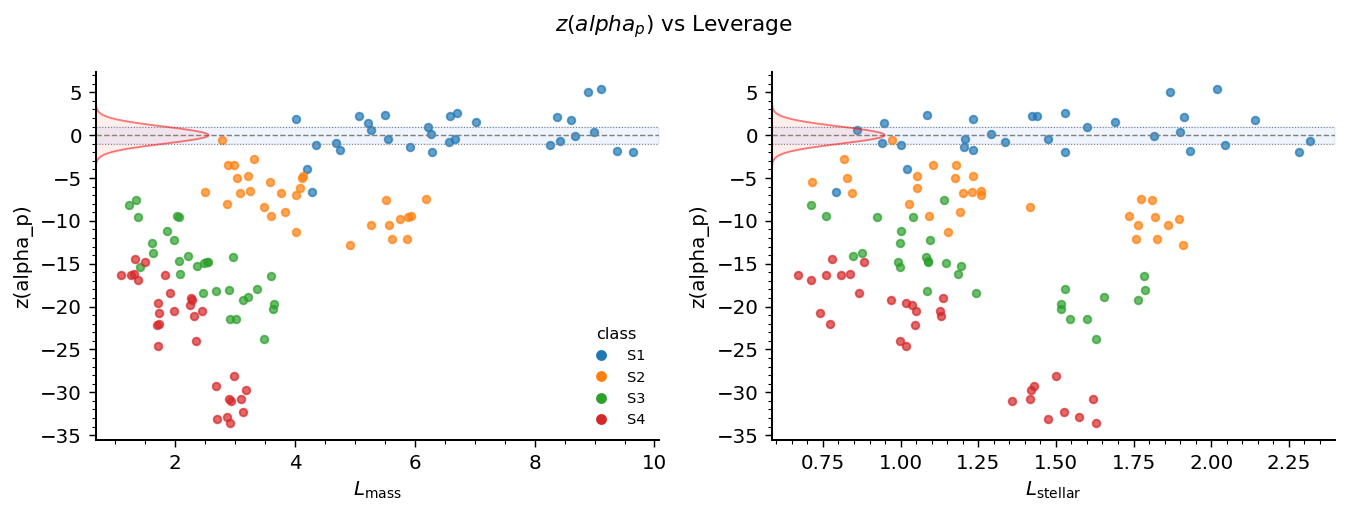

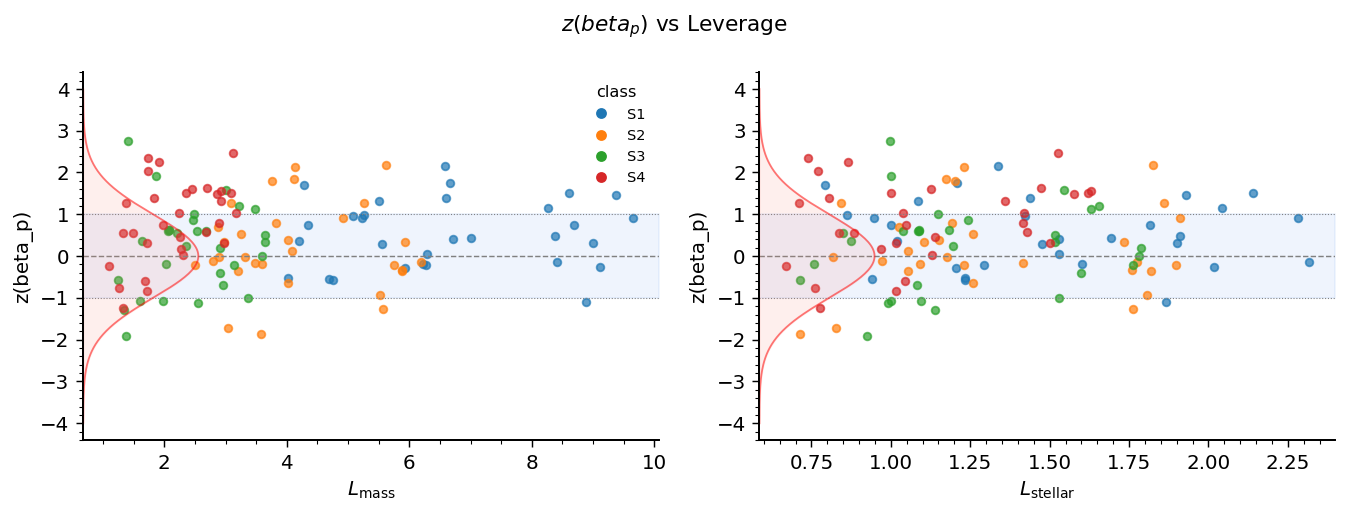

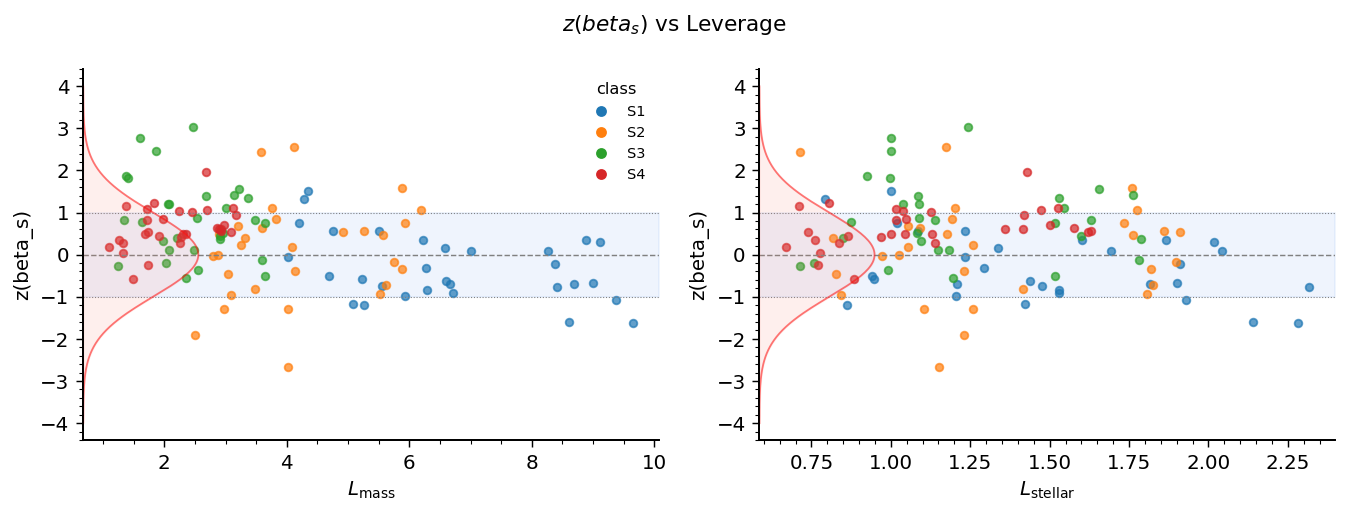

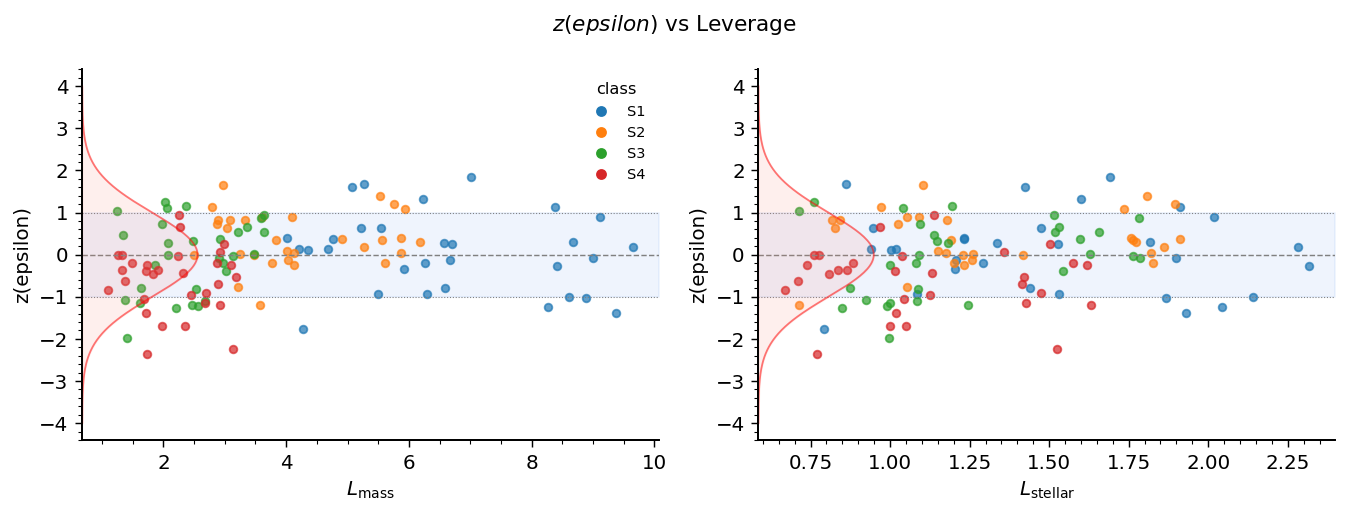

In [30]:
# Z vs both leverages
for p in z_params:
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
    fig.suptitle(rf'$z({p})$ vs Leverage', fontsize=12)
    
    for ax, Lcol, Llab in [(axes[0], 'L_mass', r'$L_{\mathrm{mass}}$'),
                            (axes[1], 'L_stellar', r'$L_{\mathrm{stellar}}$')]:
        for cls in CLS_ORD:
            cm = df_z['class_label'] == cls
            if not cm.any():
                continue
            ax.scatter(df_z.loc[cm, Lcol], df_z.loc[cm, f'z_{p}'],
                      s=18, alpha=0.7, color=CLS_CLR.get(cls, 'k'), label=cls)
        
        # +/-1 sigma shaded band
        xlims = ax.get_xlim()
        ax.fill_between(xlims, -1, 1, alpha=0.10, color='cornflowerblue', zorder=0)
        ax.set_xlim(xlims)
        ax.axhline(0, color='grey', ls='--', lw=0.8)
        ax.axhline(1, color='grey', ls=':', lw=0.6)
        ax.axhline(-1, color='grey', ls=':', lw=0.6)
        
        # Sideways N(0,1) Gaussian reference
        ax_g = ax.twiny()
        ax_g.fill_betweenx(xgrid, 0, gauss, alpha=0.12, color='salmon', zorder=0)
        ax_g.plot(gauss, xgrid, 'r-', lw=1.0, alpha=0.5)
        ax_g.set_xlim(0, gauss.max()*5)
        ax_g.xaxis.set_visible(False)
        
        ax.set_xlabel(Llab)
        ax.set_ylabel(f'z({p})')
        ax.minorticks_on()
    
    add_legend(axes[0], df_z)
    fig.tight_layout()
    plt.savefig(f'z_{p}_vs_leverage.pdf', bbox_inches='tight')
    plt.show()

In [34]:
from IPython.display import display, HTML

In [35]:
# Z-score tables for ApJ: top 5 best-calibrated surveys PER CLASS
df_zt = df_results[(df_results['model']==PRIMARY)&(df_results['seed']==MCMC_SEEDS[0])].copy()
z_params = [p for p in ['alpha_p','beta_p','beta_s','epsilon'] if f'z_{p}' in df_zt.columns]
df_zt['mean_abs_z'] = df_zt[[f'z_{p}' for p in z_params]].abs().mean(axis=1)

nice_names = {'alpha_p': r'$\alpha_p$', 'beta_p': r'$\beta_p$',
              'beta_s': r'$\beta_s$', 'epsilon': r'$\varepsilon$'}
pd.set_option('display.max_columns', None)                                    
pd.set_option('display.max_colwidth', None)                                   
pd.set_option('display.width', None) 

for cls in ['S1','S2','S3','S4']:
    sub = df_zt[df_zt['class_label']==cls].nsmallest(5, 'mean_abs_z')
    rows = []
    for _, r in sub.iterrows():
        row = {
            'Survey': int(r['survey_id']),
            r'$N$': int(r['N']),
            r'$L_{\mathrm{mass}}$':    round(r['L_mass'], 2),
            r'$L_{\mathrm{stellar}}$': round(r['L_stellar'], 2),
        }
        for p in z_params:
            row[nice_names[p]] = f"${r[f'z_{p}']:+.2f}$"
        row[r'$\langle |z| \rangle$'] = f"${r['mean_abs_z']:.2f}$"
        rows.append(row)
    
    tab = pd.DataFrame(rows)
    latex_str = tab.to_latex(index=False, escape=False,
                               column_format='c'*len(tab.columns),
                               caption=f'Top 5 best-calibrated surveys in class
  {cls}. '
                                       r'$z_\theta = (\hat\theta -
  \theta_{\mathrm{ref}})/\sigma_\theta$; '
                                       r'well-calibrated posteriors yield $|z|
  \lesssim 1$.',
                               label=f'tab:zscores_{cls}')
    print(latex_str)

    display(HTML(tab.to_html(escape=False)))

\begin{table}
\caption{Top 5 best-calibrated surveys in class S1. $z_\theta = (\hat\theta - \theta_{\mathrm{ref}})/\sigma_\theta$; well-calibrated posteriors yield $|z| \lesssim 1$.}
\label{tab:zscores_S1}
\begin{tabular}{ccccccccc}
\toprule
Survey & $N$ & $L_{\mathrm{mass}}$ & $L_{\mathrm{stellar}}$ & $\alpha_p$ & $\beta_p$ & $\beta_s$ & $\varepsilon$ & $\langle |z| \rangle$ \\
\midrule
16 & 50 & 6.270000 & 1.290000 & $+0.08$ & $-0.22$ & $-0.32$ & $-0.20$ & $0.21$ \\
26 & 100 & 8.990000 & 1.900000 & $+0.39$ & $+0.31$ & $-0.67$ & $-0.08$ & $0.36$ \\
23 & 100 & 8.680000 & 1.820000 & $-0.13$ & $+0.75$ & $-0.70$ & $+0.29$ & $0.47$ \\
29 & 100 & 8.420000 & 2.320000 & $-0.70$ & $-0.15$ & $-0.76$ & $-0.26$ & $0.47$ \\
13 & 50 & 5.550000 & 1.470000 & $-0.42$ & $+0.29$ & $-0.75$ & $+0.64$ & $0.52$ \\
\bottomrule
\end{tabular}
\end{table}




,Survey,$N$,$L_{\mathrm{mass}}$,$L_{\mathrm{stellar}}$,$\alpha_p$,$\beta_p$,$\beta_s$,$\varepsilon$,$\langle |z| \rangle$
0,16,50,6.27,1.29,$+0.08$,$-0.22$,$-0.32$,$-0.20$,$0.21$
1,26,100,8.99,1.90,$+0.39$,$+0.31$,$-0.67$,$-0.08$,$0.36$
2,23,100,8.68,1.82,$-0.13$,$+0.75$,$-0.70$,$+0.29$,$0.47$
3,29,100,8.42,2.32,$-0.70$,$-0.15$,$-0.76$,$-0.26$,$0.47$
4,13,50,5.55,1.47,$-0.42$,$+0.29$,$-0.75$,$+0.64$,$0.52$


\begin{table}
\caption{Top 5 best-calibrated surveys in class S2. $z_\theta = (\hat\theta - \theta_{\mathrm{ref}})/\sigma_\theta$; well-calibrated posteriors yield $|z| \lesssim 1$.}
\label{tab:zscores_S2}
\begin{tabular}{ccccccccc}
\toprule
Survey & $N$ & $L_{\mathrm{mass}}$ & $L_{\mathrm{stellar}}$ & $\alpha_p$ & $\beta_p$ & $\beta_s$ & $\varepsilon$ & $\langle |z| \rangle$ \\
\midrule
31 & 30 & 2.790000 & 0.970000 & $-0.54$ & $-0.11$ & $-0.03$ & $+1.13$ & $0.45$ \\
37 & 30 & 3.320000 & 0.820000 & $-2.85$ & $-0.02$ & $+0.40$ & $+0.83$ & $1.03$ \\
35 & 30 & 2.890000 & 1.180000 & $-3.53$ & $-0.03$ & $+0.48$ & $+0.83$ & $1.22$ \\
34 & 30 & 3.210000 & 1.050000 & $-4.77$ & $-0.36$ & $+0.67$ & $-0.76$ & $1.64$ \\
39 & 30 & 2.980000 & 1.100000 & $-3.47$ & $+0.34$ & $-1.30$ & $+1.65$ & $1.69$ \\
\bottomrule
\end{tabular}
\end{table}




,Survey,$N$,$L_{\mathrm{mass}}$,$L_{\mathrm{stellar}}$,$\alpha_p$,$\beta_p$,$\beta_s$,$\varepsilon$,$\langle |z| \rangle$
0,31,30,2.79,0.97,$-0.54$,$-0.11$,$-0.03$,$+1.13$,$0.45$
1,37,30,3.32,0.82,$-2.85$,$-0.02$,$+0.40$,$+0.83$,$1.03$
2,35,30,2.89,1.18,$-3.53$,$-0.03$,$+0.48$,$+0.83$,$1.22$
3,34,30,3.21,1.05,$-4.77$,$-0.36$,$+0.67$,$-0.76$,$1.64$
4,39,30,2.98,1.10,$-3.47$,$+0.34$,$-1.30$,$+1.65$,$1.69$


\begin{table}
\caption{Top 5 best-calibrated surveys in class S3. $z_\theta = (\hat\theta - \theta_{\mathrm{ref}})/\sigma_\theta$; well-calibrated posteriors yield $|z| \lesssim 1$.}
\label{tab:zscores_S3}
\begin{tabular}{ccccccccc}
\toprule
Survey & $N$ & $L_{\mathrm{mass}}$ & $L_{\mathrm{stellar}}$ & $\alpha_p$ & $\beta_p$ & $\beta_s$ & $\varepsilon$ & $\langle |z| \rangle$ \\
\midrule
70 & 30 & 1.240000 & 0.710000 & $-8.16$ & $-0.56$ & $-0.26$ & $+1.03$ & $2.50$ \\
62 & 30 & 1.340000 & 1.140000 & $-7.53$ & $-1.30$ & $+0.83$ & $+0.46$ & $2.53$ \\
61 & 30 & 2.030000 & 0.760000 & $-9.40$ & $-0.20$ & $-0.21$ & $+1.25$ & $2.76$ \\
68 & 30 & 2.070000 & 1.040000 & $-9.56$ & $+0.59$ & $+1.20$ & $+1.11$ & $3.11$ \\
80 & 50 & 1.980000 & 1.090000 & $-12.30$ & $-1.07$ & $+0.32$ & $+0.73$ & $3.60$ \\
\bottomrule
\end{tabular}
\end{table}




,Survey,$N$,$L_{\mathrm{mass}}$,$L_{\mathrm{stellar}}$,$\alpha_p$,$\beta_p$,$\beta_s$,$\varepsilon$,$\langle |z| \rangle$
0,70,30,1.24,0.71,$-8.16$,$-0.56$,$-0.26$,$+1.03$,$2.50$
1,62,30,1.34,1.14,$-7.53$,$-1.30$,$+0.83$,$+0.46$,$2.53$
2,61,30,2.03,0.76,$-9.40$,$-0.20$,$-0.21$,$+1.25$,$2.76$
3,68,30,2.07,1.04,$-9.56$,$+0.59$,$+1.20$,$+1.11$,$3.11$
4,80,50,1.98,1.09,$-12.30$,$-1.07$,$+0.32$,$+0.73$,$3.60$


\begin{table}
\caption{Top 5 best-calibrated surveys in class S4. $z_\theta = (\hat\theta - \theta_{\mathrm{ref}})/\sigma_\theta$; well-calibrated posteriors yield $|z| \lesssim 1$.}
\label{tab:zscores_S4}
\begin{tabular}{ccccccccc}
\toprule
Survey & $N$ & $L_{\mathrm{mass}}$ & $L_{\mathrm{stellar}}$ & $\alpha_p$ & $\beta_p$ & $\beta_s$ & $\varepsilon$ & $\langle |z| \rangle$ \\
\midrule
91 & 30 & 1.330000 & 0.780000 & $-14.49$ & $-1.23$ & $+0.03$ & $-0.01$ & $3.94$ \\
92 & 30 & 1.490000 & 0.880000 & $-14.84$ & $+0.56$ & $-0.57$ & $-0.19$ & $4.04$ \\
99 & 30 & 1.260000 & 0.760000 & $-16.28$ & $-0.76$ & $+0.34$ & $-0.01$ & $4.35$ \\
94 & 30 & 1.320000 & 0.840000 & $-16.23$ & $+0.56$ & $+0.27$ & $-0.37$ & $4.35$ \\
98 & 30 & 1.100000 & 0.670000 & $-16.37$ & $-0.23$ & $+0.18$ & $-0.84$ & $4.40$ \\
\bottomrule
\end{tabular}
\end{table}




,Survey,$N$,$L_{\mathrm{mass}}$,$L_{\mathrm{stellar}}$,$\alpha_p$,$\beta_p$,$\beta_s$,$\varepsilon$,$\langle |z| \rangle$
0,91,30,1.33,0.78,$-14.49$,$-1.23$,$+0.03$,$-0.01$,$3.94$
1,92,30,1.49,0.88,$-14.84$,$+0.56$,$-0.57$,$-0.19$,$4.04$
2,99,30,1.26,0.76,$-16.28$,$-0.76$,$+0.34$,$-0.01$,$4.35$
3,94,30,1.32,0.84,$-16.23$,$+0.56$,$+0.27$,$-0.37$,$4.35$
4,98,30,1.10,0.67,$-16.37$,$-0.23$,$+0.18$,$-0.84$,$4.40$


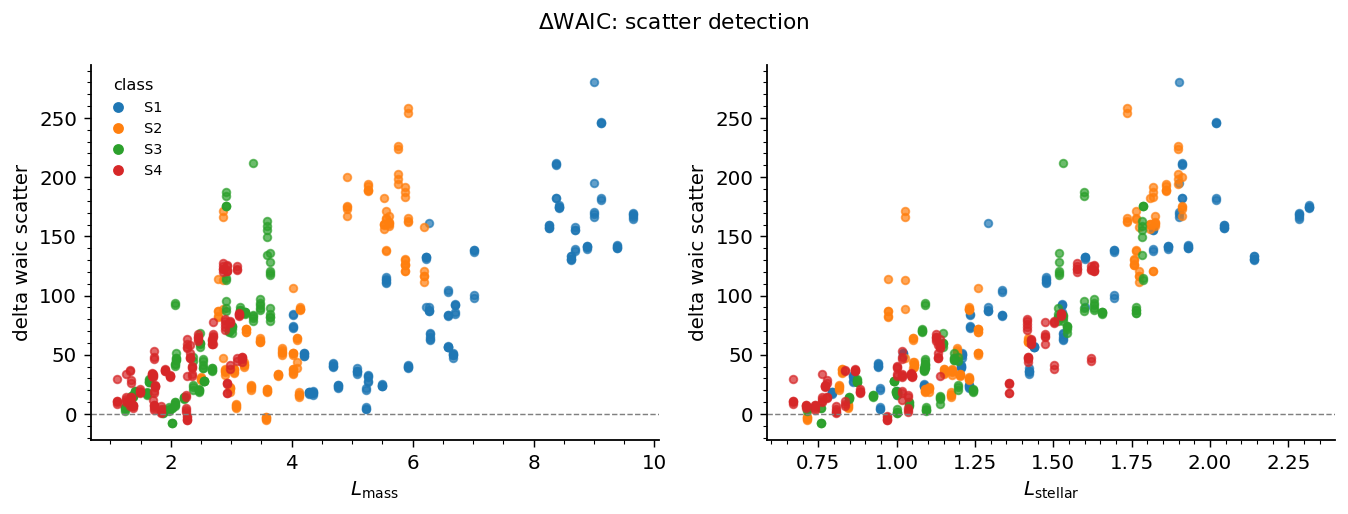

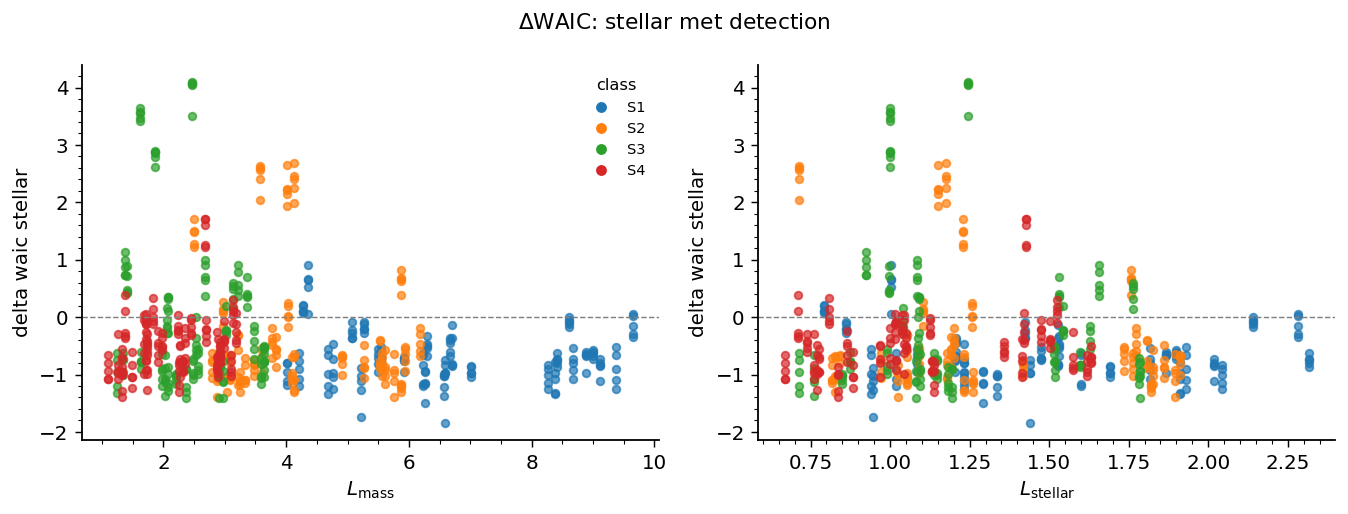

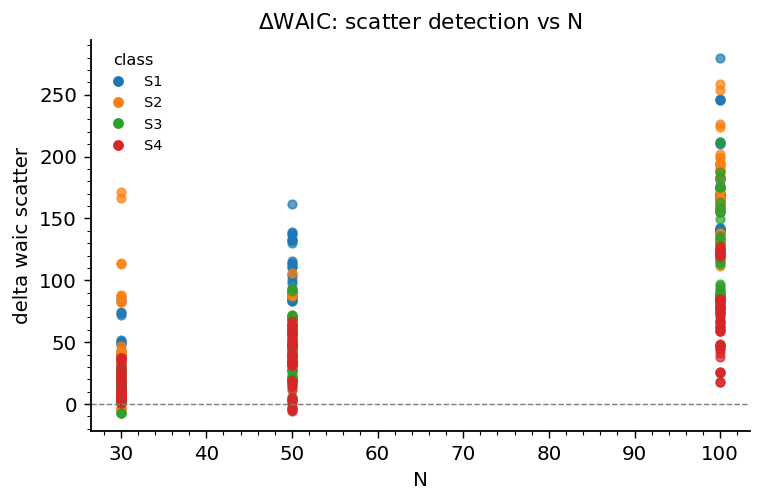

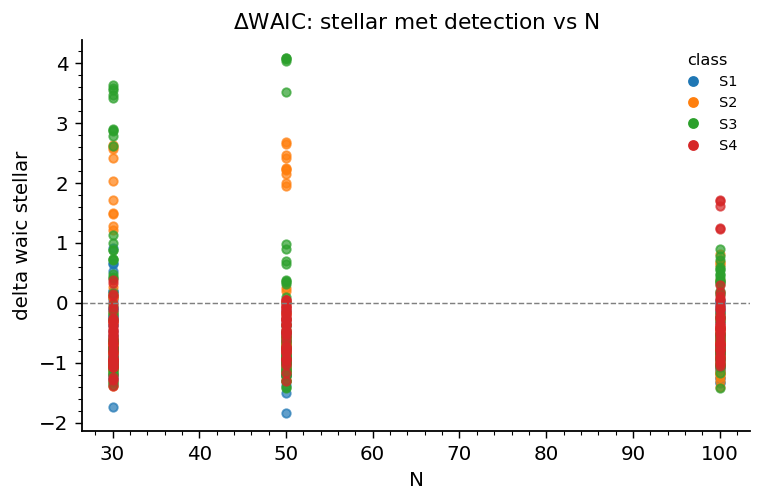

In [18]:
if waic_wide is not None:
    delta_cols = [c for c in ['delta_waic_scatter','delta_waic_stellar'] if c in waic_wide.columns]
    titles = {'delta_waic_scatter': r'$\Delta$WAIC: scatter detection',
              'delta_waic_stellar': r'$\Delta$WAIC: stellar met detection'}

    # vs L_mass and L_stellar
    for dc in delta_cols:
        fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
        fig.suptitle(titles.get(dc, dc), fontsize=12)
        labels = waic_wide['class_label'].to_numpy(str)
        for ax, Lcol, Llab in [(axes[0], 'L_mass', r'$L_{\mathrm{mass}}$'),
                                (axes[1], 'L_stellar', r'$L_{\mathrm{stellar}}$')]:
            vals = waic_wide[dc].values
            Lv = waic_wide[Lcol].values
            for cls in CLS_ORD:
                cm = labels == cls
                if not cm.any():
                    continue
                ax.scatter(Lv[cm], vals[cm], s=18, alpha=0.7,
                           color=CLS_CLR.get(cls,'k'), label=cls)
            ax.axhline(0, color='grey', ls='--', lw=0.8)
            ax.set_xlabel(Llab)
            ax.set_ylabel(dc.replace('_',' '))
            ax.minorticks_on()
        add_legend(axes[0], waic_wide)
        fig.tight_layout()
        plt.show()

    # vs N
    for dc in delta_cols:
        fig, ax = plt.subplots(figsize=(6, 4))
        labels = waic_wide['class_label'].to_numpy(str)
        for cls in CLS_ORD:
            cm = labels == cls
            if not cm.any():
                continue
            ax.scatter(waic_wide.loc[cm, 'N'], waic_wide.loc[cm, dc],
                       s=22, alpha=0.7, color=CLS_CLR.get(cls,'k'), label=cls)
        ax.axhline(0, color='grey', ls='--', lw=0.8)
        ax.set_xlabel('N')
        ax.set_ylabel(dc.replace('_',' '))
        ax.set_title(titles.get(dc, dc) + ' vs N')
        ax.minorticks_on()
        add_legend(ax, waic_wide)
        fig.tight_layout()
        plt.show()
else:
    print('WAIC not computed -- skipping plots.')

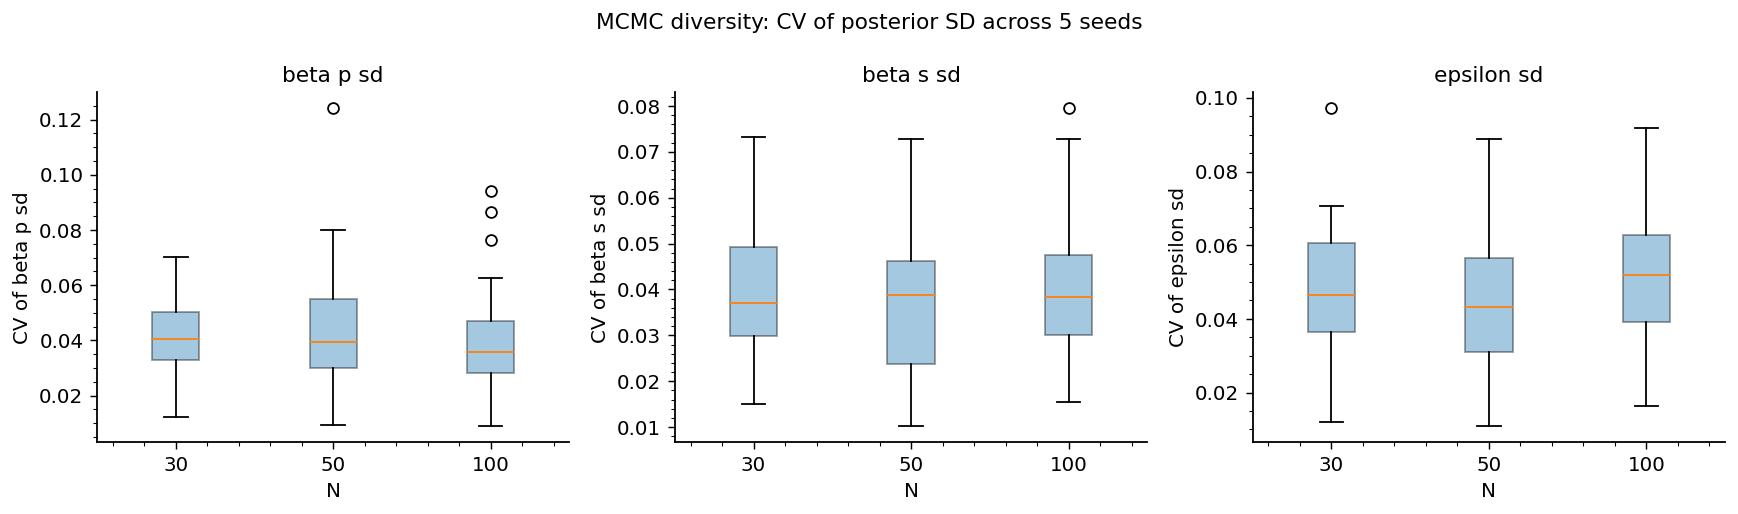

In [19]:
# Multi-seed diversity: how much do posteriors change across MCMC seeds?
if len(MCMC_SEEDS) > 1:
    df_div = df_results[df_results['model'] == PRIMARY].copy()
    params = [p for p in ['beta_p_sd','beta_s_sd','epsilon_sd'] if p in df_div.columns]

    # For each survey, compute the CV of sigma across seeds
    grouped = df_div.groupby('survey_id')
    div_rows = []
    for sid, grp in grouped:
        row = {'survey_id': sid, 'N': grp['N'].iloc[0],
               'class_label': grp['class_label'].iloc[0],
               'L_mass': grp['L_mass'].iloc[0],
               'L_stellar': grp['L_stellar'].iloc[0]}
        for p in params:
            vals = grp[p].dropna()
            if len(vals) > 1:
                row[f'{p}_cv'] = float(vals.std() / vals.mean()) if vals.mean() > 0 else np.nan
        div_rows.append(row)
    df_div_summary = pd.DataFrame(div_rows)

    # Box plot of CV by N
    cv_cols = [c for c in df_div_summary.columns if c.endswith('_cv')]
    if cv_cols:
        fig, axes = plt.subplots(1, len(cv_cols), figsize=(4.5*len(cv_cols), 4))
        if len(cv_cols) == 1:
            axes = [axes]
        fig.suptitle(f'MCMC diversity: CV of posterior SD across {len(MCMC_SEEDS)} seeds', fontsize=12)
        for ax, col in zip(axes, cv_cols):
            data = [df_div_summary.loc[df_div_summary['N']==N0, col].dropna()
                    for N0 in sorted(df_div_summary['N'].unique())]
            bp = ax.boxplot(data, labels=[str(n) for n in sorted(df_div_summary['N'].unique())],
                           patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor('C0')
                patch.set_alpha(0.4)
            ax.set_xlabel('N')
            pname = col.replace('_cv','').replace('_',' ')
            ax.set_ylabel(f'CV of {pname}')
            ax.set_title(pname)
            ax.minorticks_on()
        fig.tight_layout()
        plt.show()
else:
    print('Only 1 seed -- skipping diversity analysis.')

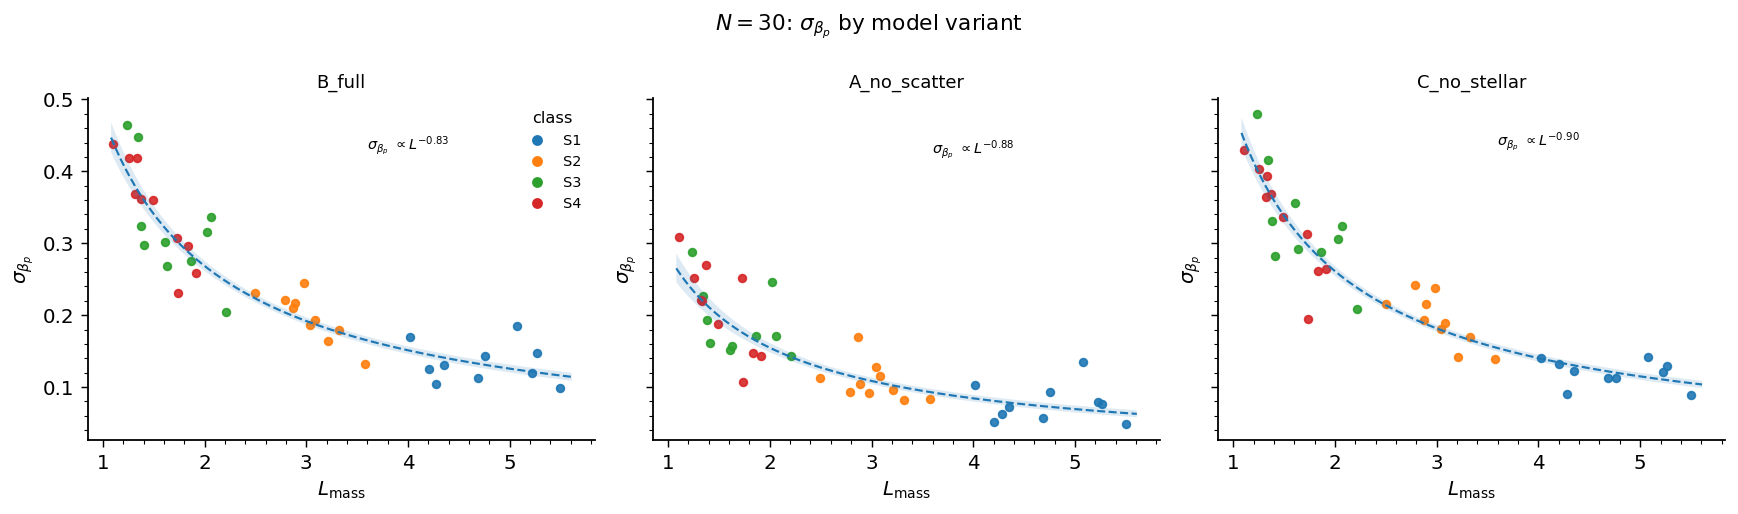

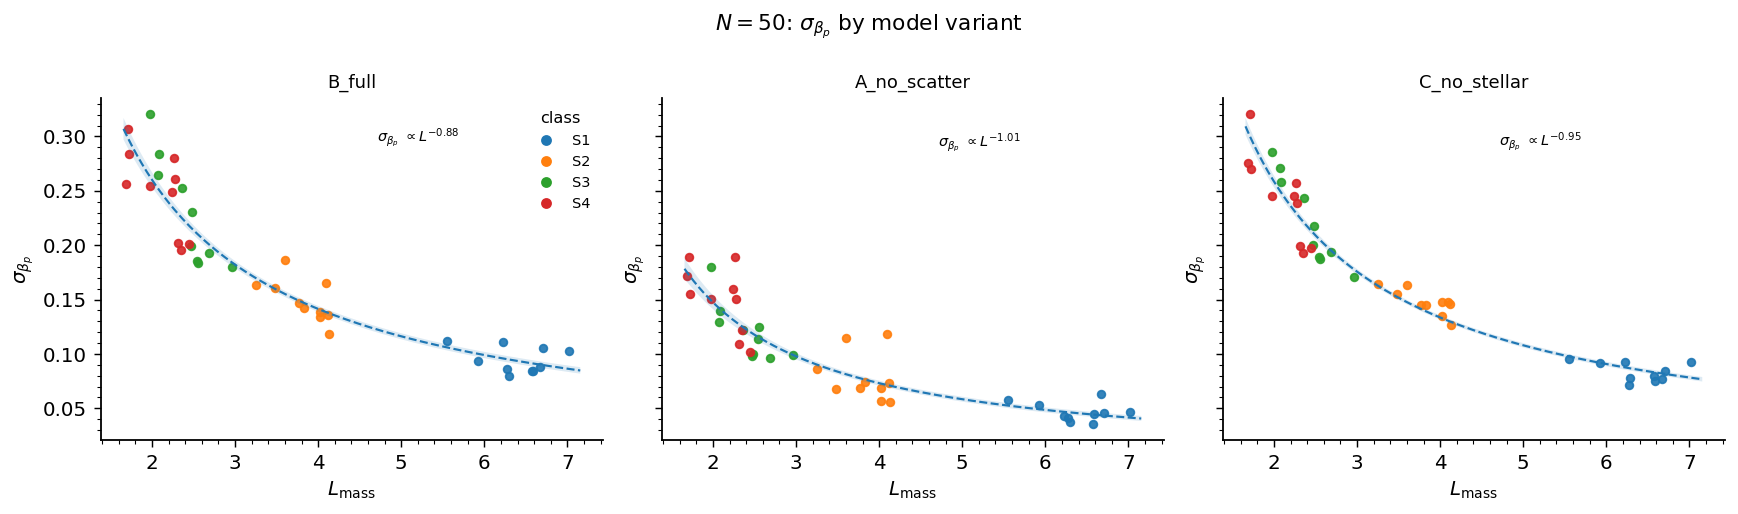

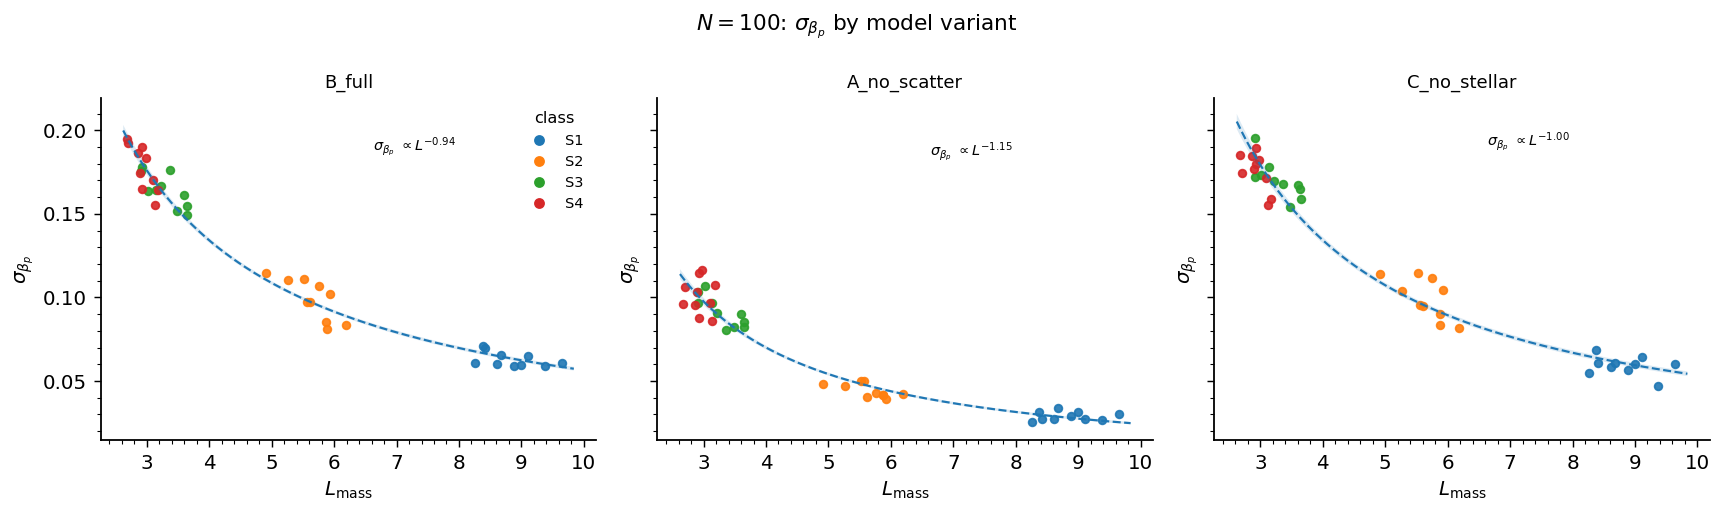

In [20]:
# Compare sigma(beta_p) across model variants (scatter toggle effect)
seed0 = MCMC_SEEDS[0]
model_names = df_results['model'].unique()
n_models = len(model_names)

for N0 in sorted(df_results['N'].unique()):
    sub = df_results[(df_results['N'] == N0) & (df_results['seed'] == seed0)]
    if len(sub) < 3:
        continue

    fig, axes = plt.subplots(1, n_models, figsize=(4.5*n_models, 4), sharey=True)
    if n_models == 1:
        axes = [axes]
    fig.suptitle(rf'$N={N0}$: $\sigma_{{\beta_p}}$ by model variant', fontsize=12)

    for ax, mn in zip(axes, model_names):
        msub = sub[sub['model'] == mn]
        if msub.empty:
            ax.set_title(mn)
            continue
        labels = msub['class_label'].to_numpy(str)
        scatter_fits(ax, msub['L_mass'].values, msub['beta_p_sd'].values,
                     labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{mass}}$')
        ax.set_title(mn, fontsize=10)
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.savefig(f'beta_p_sd_comparison_N{N0}.pdf', bbox_inches='tight')
    plt.show()

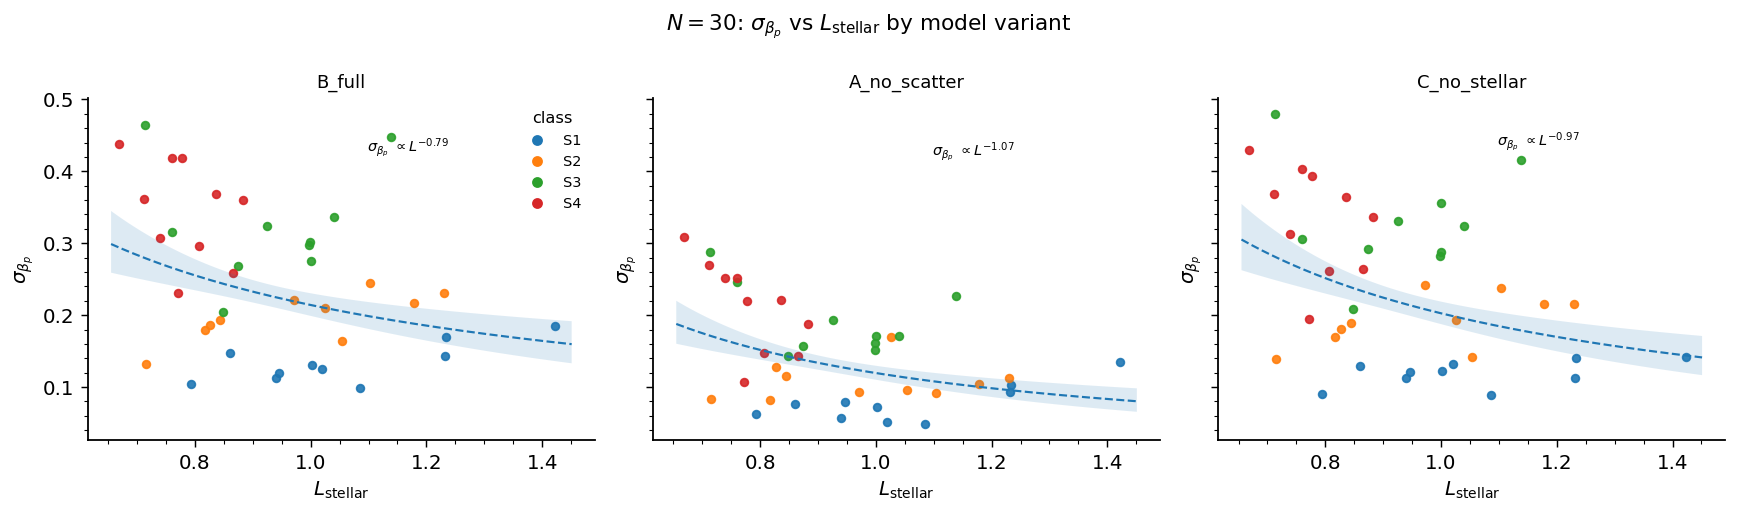

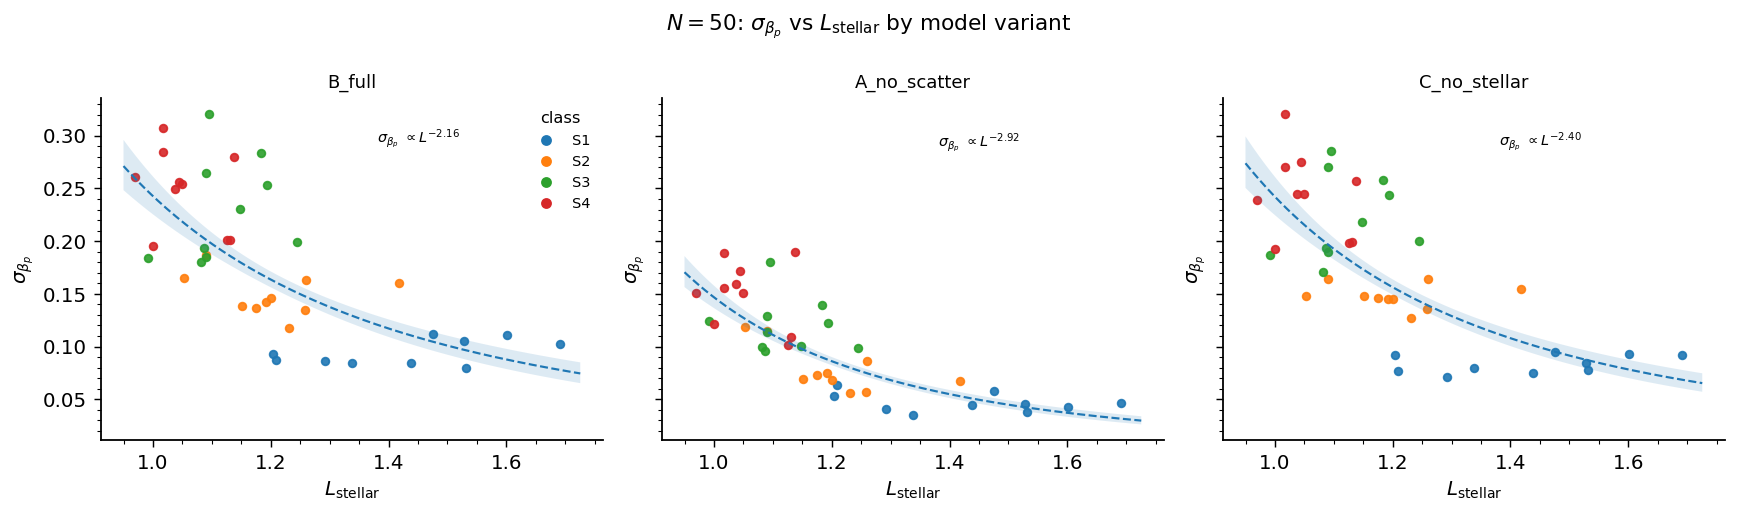

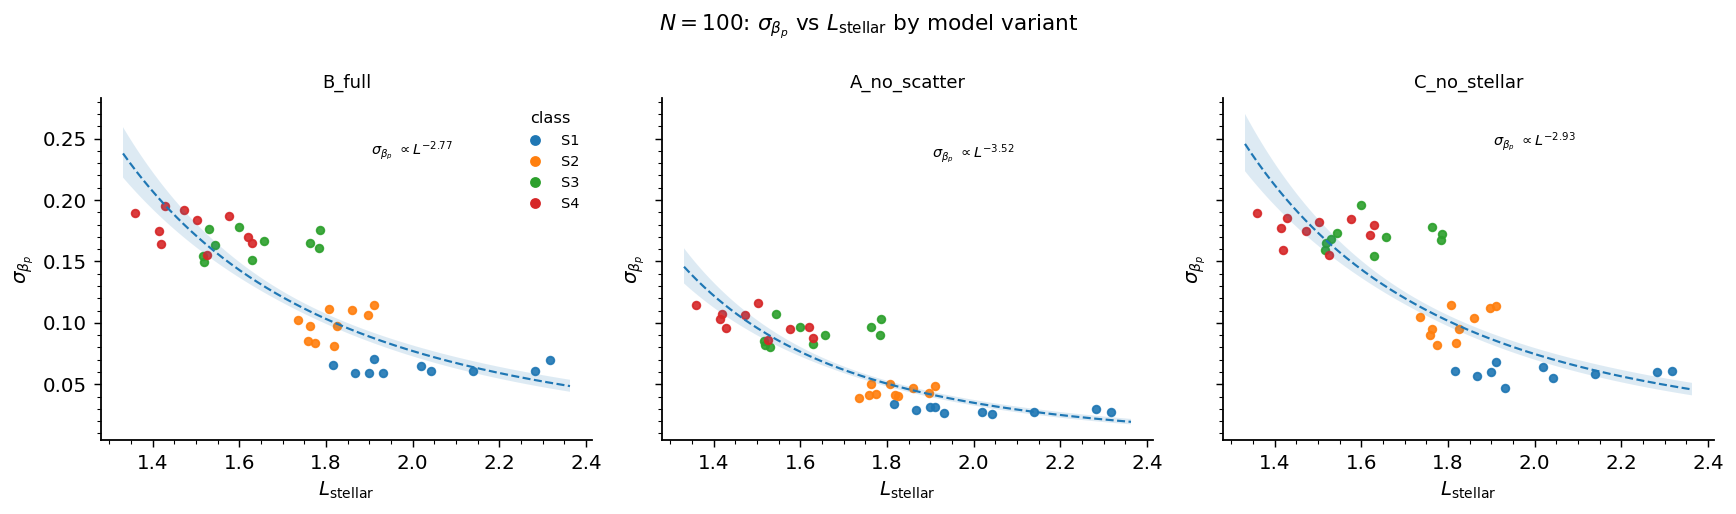

In [21]:
# Plot sigma(beta_p) vs L_stellar for each model variant (fixed-N panels)

for N0 in sorted(df_results['N'].unique()):
    sub = df_results[(df_results['N'] == N0) & (df_results['seed'] == seed0)]
    if len(sub) < 3:
        continue

    fig, axes = plt.subplots(1, n_models, figsize=(4.5*n_models, 4), sharey=True)
    if n_models == 1:
        axes = [axes]
    fig.suptitle(rf'$N={N0}$: $\sigma_{{\beta_p}}$ vs $L_{{\mathrm{{stellar}}}}$ by model variant', fontsize=12)

    for ax, mn in zip(axes, model_names):
        msub = sub[sub['model'] == mn]
        if msub.empty:
            ax.set_title(mn)
            continue
        labels = msub['class_label'].to_numpy(str)
        scatter_fits(ax, msub['L_stellar'].values, msub['beta_p_sd'].values,
                     labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{stellar}}$')
        ax.set_title(mn, fontsize=10)
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.savefig(f'beta_p_sd_comparison_stellar_N{N0}.pdf', bbox_inches='tight')
    plt.show()

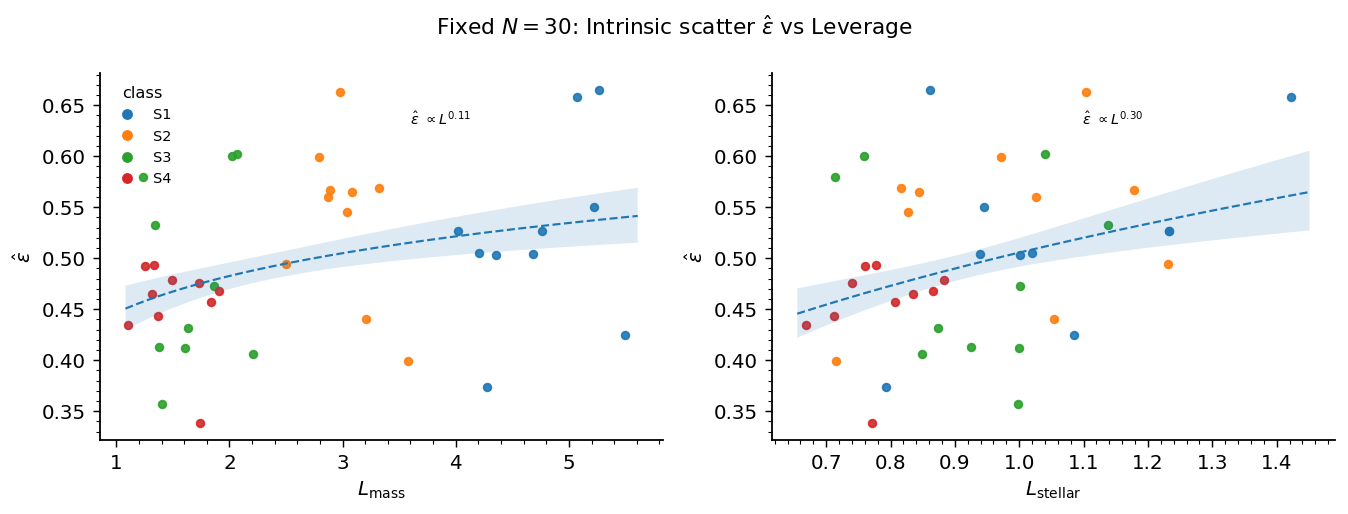

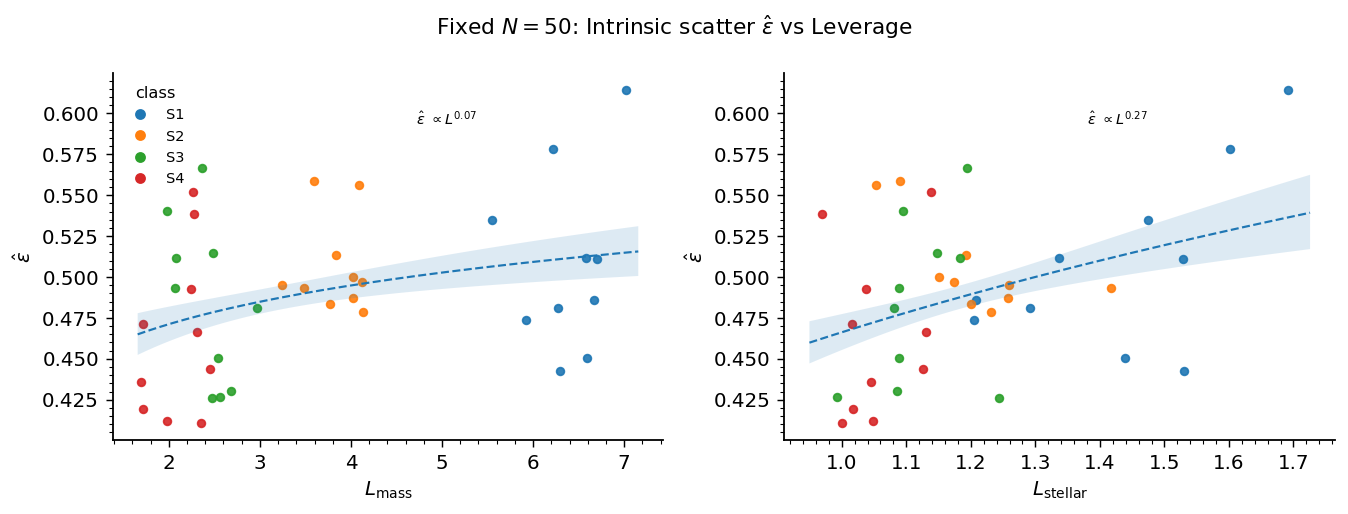

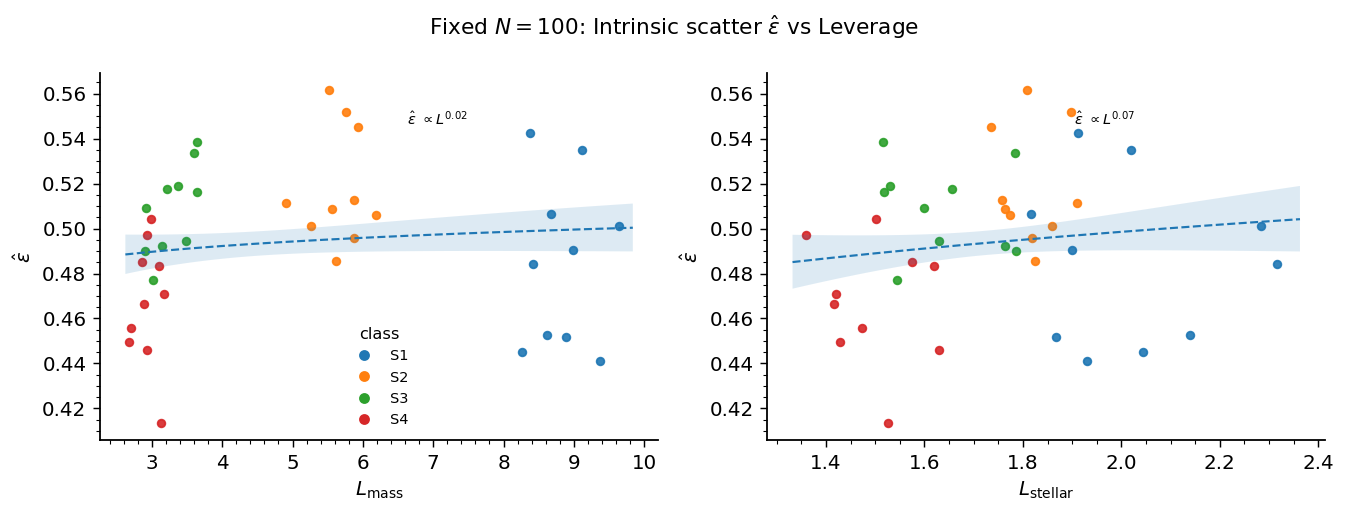

In [22]:
# Posterior mean intrinsic scatter vs leverage (matching HERMES scatter plot)
df_sc = df_results[(df_results['model'] == PRIMARY) &
                   (df_results['seed'] == MCMC_SEEDS[0])].copy()

if 'epsilon_mean' in df_sc.columns:
    for N0 in sorted(df_sc['N'].unique()):
        sub = df_sc[df_sc['N'] == N0]
        if len(sub) < 3:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
        fig.suptitle(rf'Fixed $N={N0}$: Intrinsic scatter $\hat\varepsilon$ vs Leverage',
                     fontsize=12)
        labels = sub['class_label'].to_numpy(str)
        scatter_fits(axes[0], sub['L_mass'].values, sub['epsilon_mean'].values,
                     labels, r'$\hat{\varepsilon}$', r'$L_{\mathrm{mass}}$')
        scatter_fits(axes[1], sub['L_stellar'].values, sub['epsilon_mean'].values,
                     labels, r'$\hat{\varepsilon}$', r'$L_{\mathrm{stellar}}$')
        add_legend(axes[0], sub)
        fig.tight_layout()
        plt.show()
else:
    print('No epsilon_mean column (scatter may be off).')

## 11. Hierarchical MetModel Extension

The **HierMetModel** adds a population layer on top of the per-survey MetModel.
The per-survey science equation is **identical** to MetModel:

$$y_k = \alpha_p^{(k)} + \beta_p^{(k)} m_c + \beta_s^{(k)} s_c + \varepsilon^{(k)}$$

But instead of independent priors per survey, parameters are drawn from a shared population:

| Level | Parameter | Distribution |
|---|---|---|
| **Population** | $\mu_{\beta_p}$ | $\mathcal{N}(0, 5)$ (weakly informative) |
| | $\tau_{\beta_p}$ | $\text{HalfNormal}(1)$ |
| | $\mu_{\beta_s}$ | $\mathcal{N}(1, 5)$ (centered at 1 like MetModel) |
| | $\tau_{\beta_s}$ | $\text{HalfNormal}(1)$ |
| | $\mu_{\alpha_p}$ | $\mathcal{N}(\bar{y}, 2)$ |
| | $\tau_{\alpha_p}$ | $\text{HalfNormal}(1)$ |
| | $\sigma_\varepsilon$ | $\text{HalfNormal}(1)$ |
| **Per-survey** | $\beta_p^{(k)}$ | $\mathcal{N}(\mu_{\beta_p}, \tau_{\beta_p})$ |
| | $\beta_s^{(k)}$ | $\mathcal{N}(\mu_{\beta_s}, \tau_{\beta_s})$ |
| | $\alpha_p^{(k)}$ | $\mathcal{N}(\mu_{\alpha_p}, \tau_{\alpha_p})$ |
| | $\varepsilon^{(k)}$ | $\text{HalfNormal}(\sigma_\varepsilon)$ |

In [23]:
def hier_met_model(*, survey_idx, x_m_c, x_s_obs, sig_meas_p, sig_meas_s,
                   y_planet, K, survey_sizes, alpha_p_mu_global):
    '''
    Hierarchical extension of MetModel.
    Same science equation, shared population hyperpriors.
    survey_idx : (N_total,) int array mapping each obs to its survey 0..K-1
    x_m_c      : (N_total,) mass centered PER SURVEY before concatenation
    '''
    # ---- Population hyperpriors (weakly informative) ----
    mu_alpha  = numpyro.sample('mu_alpha_p',    dist.Normal(alpha_p_mu_global, 2.0))
    mu_bp     = numpyro.sample('mu_beta_p',     dist.Normal(0.0, 5.0))
    mu_bs     = numpyro.sample('mu_beta_s',     dist.Normal(1.0, 5.0))
    tau_alpha = numpyro.sample('tau_alpha_p',    dist.HalfNormal(1.0))
    tau_bp    = numpyro.sample('tau_beta_p',     dist.HalfNormal(1.0))
    tau_bs    = numpyro.sample('tau_beta_s',     dist.HalfNormal(1.0))
    sig_eps   = numpyro.sample('sigma_epsilon',  dist.HalfNormal(1.0))

    # ---- Per-survey parameters (plate) ----
    with numpyro.plate('surveys', K):
        alpha_p = numpyro.sample('alpha_p', dist.Normal(mu_alpha, tau_alpha))
        beta_p  = numpyro.sample('beta_p',  dist.Normal(mu_bp,    tau_bp))
        beta_s  = numpyro.sample('beta_s',  dist.Normal(mu_bs,    tau_bs))
        epsilon = numpyro.sample('epsilon',  dist.HalfNormal(sig_eps))

    # ---- Latent stellar metallicity (observation level) ----
    x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))

    # Center stellar met per survey using segment operations
    s_sum  = jnp.zeros(K).at[survey_idx].add(x_s_true)
    s_mean = s_sum / survey_sizes
    x_s_true_c = x_s_true - s_mean[survey_idx]

    # ---- Map survey params to observations ----
    a_k   = alpha_p[survey_idx]
    bp_k  = beta_p[survey_idx]
    bs_k  = beta_s[survey_idx]
    eps_k = epsilon[survey_idx]

    # ---- Science equation (identical to MetModel) ----
    mu = a_k + bp_k * x_m_c + bs_k * x_s_true_c
    obs_sigma = jnp.sqrt(sig_meas_p**2 + eps_k**2)
    numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)

print('Hierarchical MetModel defined.')

Hierarchical MetModel defined.


In [24]:
def prepare_hier_data(surveys, use_log_space=True):
    '''Concatenate all surveys into arrays for the hierarchical model.'''
    all_xmc, all_xs, all_y, all_sp, all_ss = [], [], [], [], []
    idx_list = []
    sizes = []

    for k, sv in enumerate(surveys):
        df = sv.df
        xm = df['logM'].to_numpy(float)
        xmc = xm - xm.mean()  # center mass PER SURVEY (same as MetModel)
        xs = df['Star Metallicity'].to_numpy(float)
        y = df['log(X_H2O)'].to_numpy(float) if use_log_space else 10.0**df['log(X_H2O)'].to_numpy(float)
        sp = np.clip(0.5*(np.abs(df['uncertainty_lower'].to_numpy(float))
                         + np.abs(df['uncertainty_upper'].to_numpy(float))), 1e-6, None)
        ss = np.clip(0.5*(np.abs(df['Star Metallicity Error Lower'].to_numpy(float))
                         + np.abs(df['Star Metallicity Error Upper'].to_numpy(float))), 1e-6, None)
        if not use_log_space:
            sp = np.abs(y) * sp * np.log(10)
        m = np.isfinite(xmc) & np.isfinite(xs) & np.isfinite(y) & np.isfinite(sp) & np.isfinite(ss)
        all_xmc.append(xmc[m]); all_xs.append(xs[m]); all_y.append(y[m])
        all_sp.append(sp[m]); all_ss.append(ss[m])
        idx_list.extend([k]*int(m.sum()))
        sizes.append(int(m.sum()))

    y_all = np.concatenate(all_y)
    return dict(
        survey_idx = jnp.array(idx_list, dtype=jnp.int32),
        x_m_c      = jnp.array(np.concatenate(all_xmc), dtype=jnp.float32),
        x_s_obs    = jnp.array(np.concatenate(all_xs),   dtype=jnp.float32),
        sig_meas_p = jnp.array(np.concatenate(all_sp),   dtype=jnp.float32),
        sig_meas_s = jnp.array(np.concatenate(all_ss),   dtype=jnp.float32),
        y_planet   = jnp.array(y_all, dtype=jnp.float32),
        K          = len(surveys),
        survey_sizes = jnp.array(sizes, dtype=jnp.float32),
        alpha_p_mu_global = float(y_all.mean()),
    )

# ---- Fit hierarchical model ----
print('Preparing hierarchical data ...')
hier_mkw = prepare_hier_data(surveys, use_log_space=USE_LOG_SPACE)
print(f'  K={hier_mkw["K"]} surveys, N_total={len(hier_mkw["x_m_c"])} observations')

print('Fitting hierarchical model (this may take a few minutes) ...')
hier_rng = jax.random.PRNGKey(MCMC_SEEDS[0])
hier_kernel = NUTS(hier_met_model, target_accept_prob=TARGET_ACCEPT)
hier_mcmc = MCMC(hier_kernel, num_warmup=TUNE, num_samples=DRAWS,
                 num_chains=NUM_CHAINS, progress_bar=True)
hier_mcmc.run(hier_rng, **hier_mkw)
hier_idata = az.from_numpyro(hier_mcmc)
print('Hierarchical fit complete.')

# ---- Extract population-level summaries ----
hyper_params = ['mu_alpha_p','mu_beta_p','mu_beta_s','tau_alpha_p','tau_beta_p','tau_beta_s','sigma_epsilon']
print('\n=== Population-level (hyperprior) posteriors ===')
for hp in hyper_params:
    if hp in hier_idata.posterior:
        s = np.asarray(hier_idata.posterior[hp]).reshape(-1)
        print(f'  {hp:20s}: mean={s.mean():.4f}  sd={s.std():.4f}  '
              f'68%=[{np.quantile(s,0.16):.4f}, {np.quantile(s,0.84):.4f}]')

Preparing hierarchical data ...
  K=120 surveys, N_total=7200 observations
Fitting hierarchical model (this may take a few minutes) ...


sample: 100%|██████████| 1000/1000 [00:24<00:00, 41.00it/s, 63 steps of size 9.40e-02. acc. prob=0.90] 


Hierarchical fit complete.

=== Population-level (hyperprior) posteriors ===
  mu_alpha_p          : mean=-0.9164  sd=0.0418  68%=[-0.9595, -0.8743]
  mu_beta_p           : mean=-1.0988  sd=0.0111  68%=[-1.1096, -1.0874]
  mu_beta_s           : mean=0.1614  sd=0.0412  68%=[0.1218, 0.2071]
  tau_alpha_p         : mean=0.4423  sd=0.0322  68%=[0.4107, 0.4720]
  tau_beta_p          : mean=0.0294  sd=0.0120  68%=[0.0164, 0.0423]
  tau_beta_s          : mean=0.1385  sd=0.0498  68%=[0.0938, 0.1865]
  sigma_epsilon       : mean=0.5073  sd=0.0317  68%=[0.4743, 0.5385]


In [25]:
# Compare per-survey beta_p from hierarchical vs independent MetModel fits
# Extract per-survey posteriors from hierarchical model
hier_bp = np.asarray(hier_idata.posterior['beta_p'])   # (chains, draws, K)
hier_bs = np.asarray(hier_idata.posterior['beta_s'])
hier_ap = np.asarray(hier_idata.posterior['alpha_p'])
hier_ep = np.asarray(hier_idata.posterior['epsilon'])

K = hier_mkw['K']
hier_rows = []
for k in range(K):
    sv = surveys[k]
    bp_k = hier_bp[..., k].reshape(-1)
    bs_k = hier_bs[..., k].reshape(-1)
    ap_k = hier_ap[..., k].reshape(-1)
    ep_k = hier_ep[..., k].reshape(-1)
    hier_rows.append({
        'survey_id': sv.survey_id,
        'class_label': sv.class_label,
        'N': sv.n,
        'L_mass': sv.leverage('logM'),
        'L_stellar': sv.leverage('Star Metallicity'),
        'hier_beta_p_mean': float(bp_k.mean()),
        'hier_beta_p_sd':   float(bp_k.std()),
        'hier_beta_s_mean': float(bs_k.mean()),
        'hier_beta_s_sd':   float(bs_k.std()),
        'hier_alpha_p_mean': float(ap_k.mean()),
        'hier_alpha_p_sd':   float(ap_k.std()),
        'hier_epsilon_mean': float(ep_k.mean()),
        'hier_epsilon_sd':   float(ep_k.std()),
    })
df_hier = pd.DataFrame(hier_rows)

# Merge with independent fits (primary model, first seed)
df_indep = df_results[(df_results['model'] == PRIMARY) &
                      (df_results['seed'] == MCMC_SEEDS[0])].copy()
df_comp = df_indep.merge(df_hier, on=['survey_id','class_label','N','L_mass','L_stellar'])

# Shrinkage weight: w = 1 - (hier_sd / indep_sd)
# w near 1 = data dominates, w near 0 = population dominates
for p in ['beta_p', 'beta_s']:
    indep_sd = df_comp[f'{p}_sd'].values
    hier_sd  = df_comp[f'hier_{p}_sd'].values
    df_comp[f'shrinkage_{p}'] = 1.0 - np.clip(hier_sd / np.maximum(indep_sd, 1e-10), 0, 1)

print('Comparison table ready.')
print(f'\nMean shrinkage (beta_p): {df_comp["shrinkage_beta_p"].mean():.3f}')
print(f'Mean shrinkage (beta_s): {df_comp["shrinkage_beta_s"].mean():.3f}')
display(df_comp[['survey_id','class_label','N','L_mass','L_stellar',
                 'beta_p_mean','hier_beta_p_mean','beta_p_sd','hier_beta_p_sd',
                 'shrinkage_beta_p']].head(10))

Comparison table ready.

Mean shrinkage (beta_p): 0.780
Mean shrinkage (beta_s): 0.671


,survey_id,class_label,N,L_mass,L_stellar,beta_p_mean,hier_beta_p_mean,beta_p_sd,hier_beta_p_sd,shrinkage_beta_p
0,1,S1,30,4.758374,1.231986,-1.216194,-1.105267,0.142741,0.030058,0.789420
1,2,S1,30,5.221818,0.945964,-1.026642,-1.096693,0.118995,0.033956,0.714643
2,3,S1,30,4.682959,0.939338,-1.197808,-1.105693,0.113019,0.032553,0.711971
3,4,S1,30,5.075079,1.422581,-0.959749,-1.100326,0.184769,0.030749,0.833583
4,5,S1,30,5.498227,1.085631,-1.003304,-1.087117,0.098971,0.032261,0.674031
5,6,S1,30,4.352395,1.001526,-1.037239,-1.096984,0.131113,0.034789,0.734665
6,7,S1,30,4.020497,1.233322,-1.224152,-1.105778,0.169078,0.033545,0.801600
7,8,S1,30,4.277826,0.793655,-0.955105,-1.084903,0.104930,0.031396,0.700788
8,9,S1,30,5.262578,0.860604,-0.988370,-1.099546,0.147301,0.037137,0.747881
9,10,S1,30,4.204263,1.019945,-1.088666,-1.098857,0.125180,0.031677,0.746951


## 12. Hierarchical Model Plots
Shrinkage analysis and uncertainty comparison.

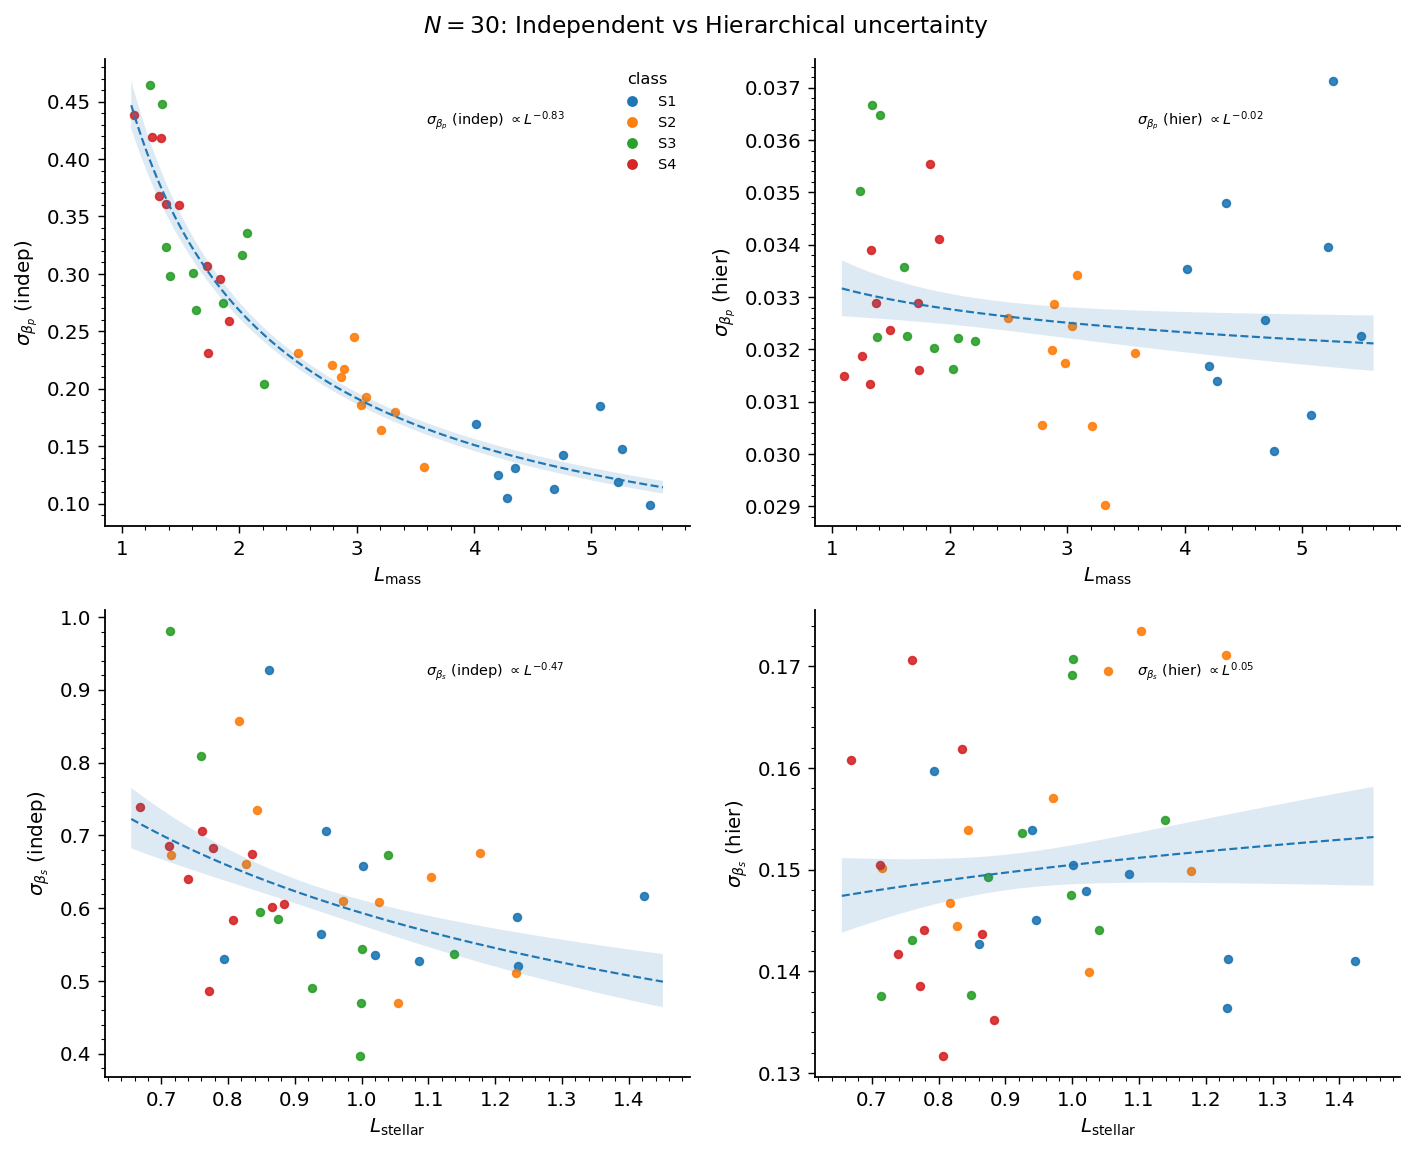

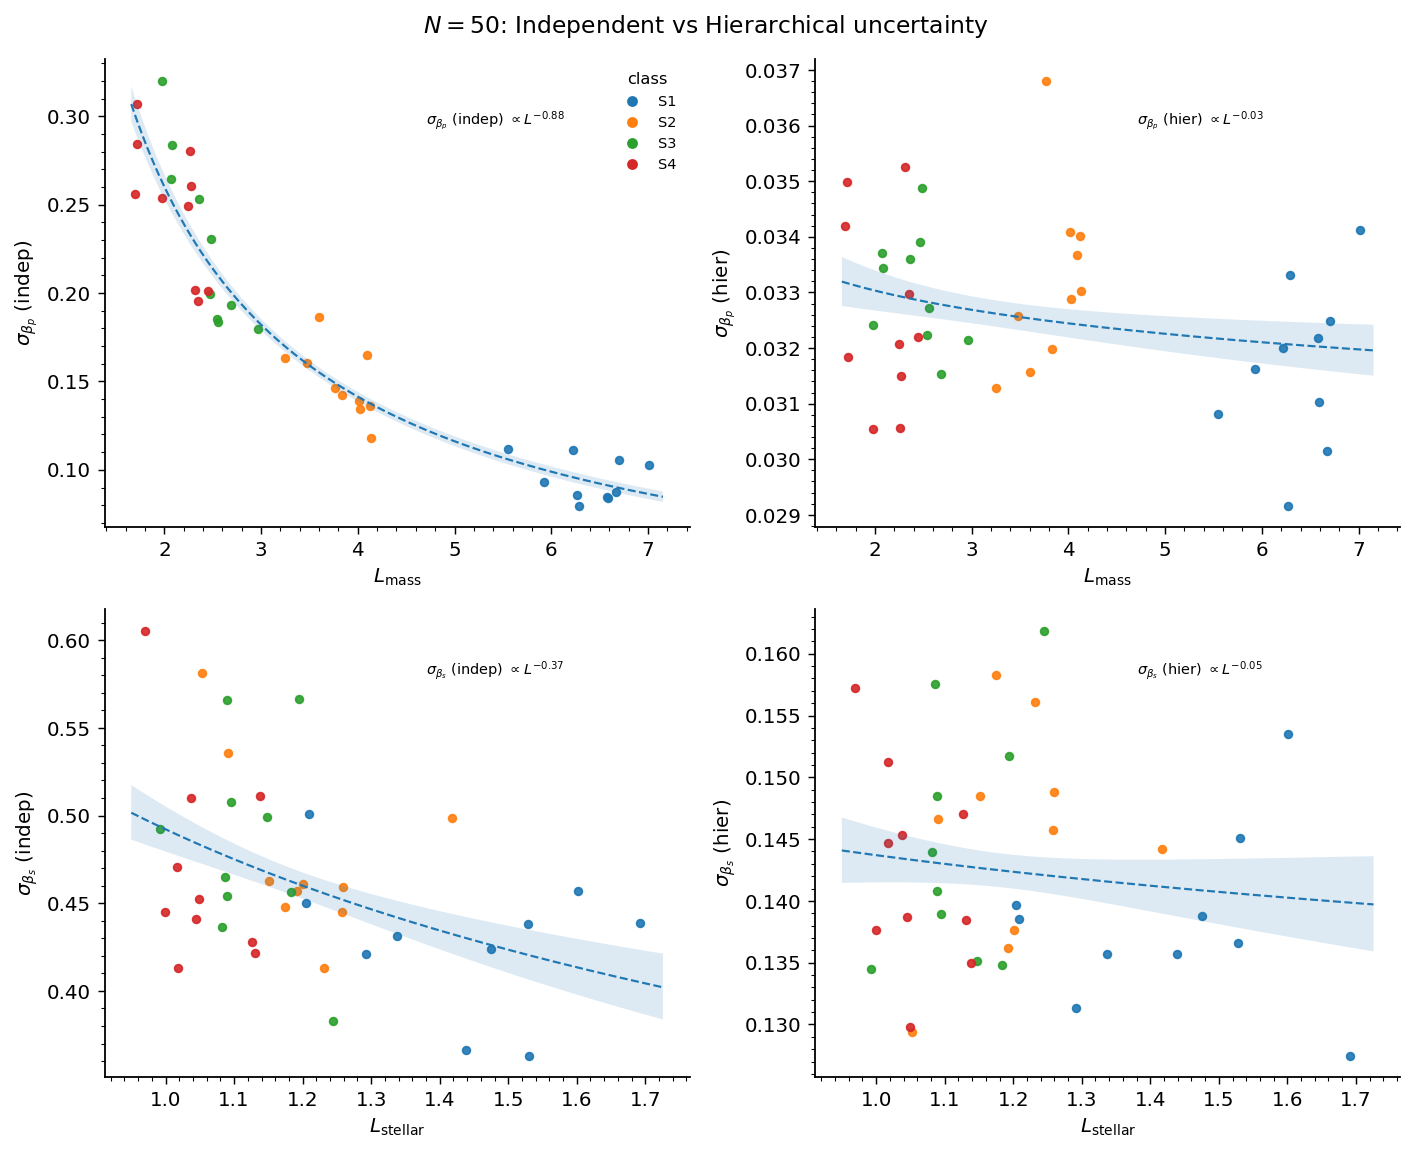

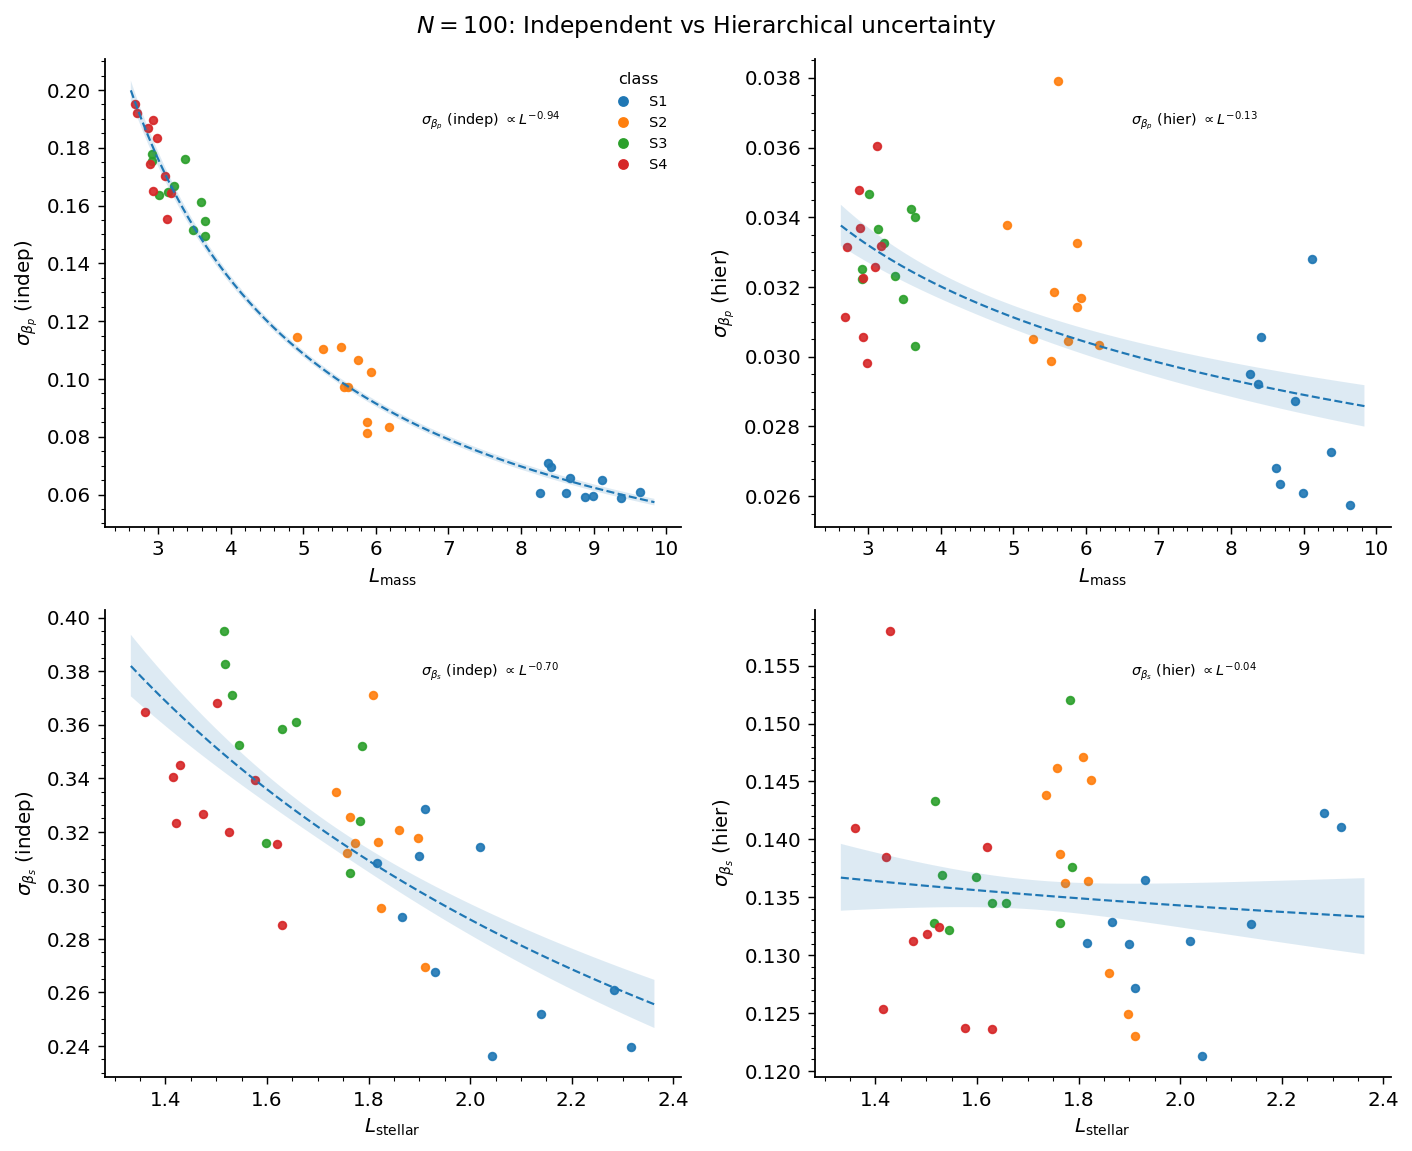

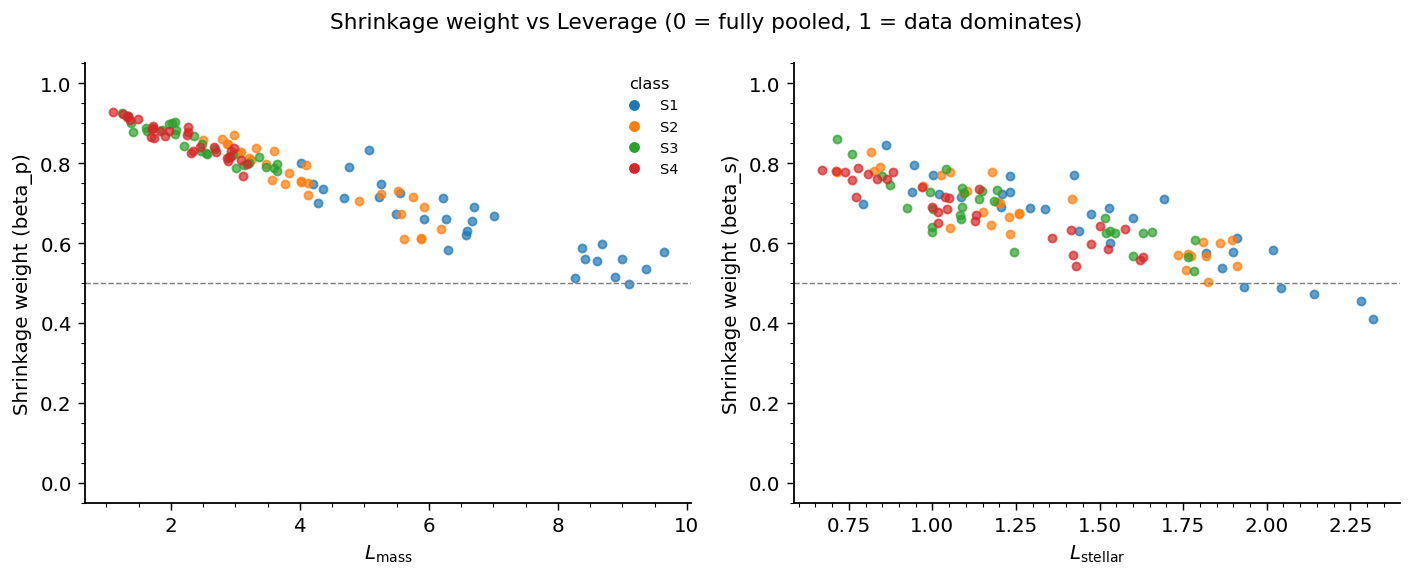

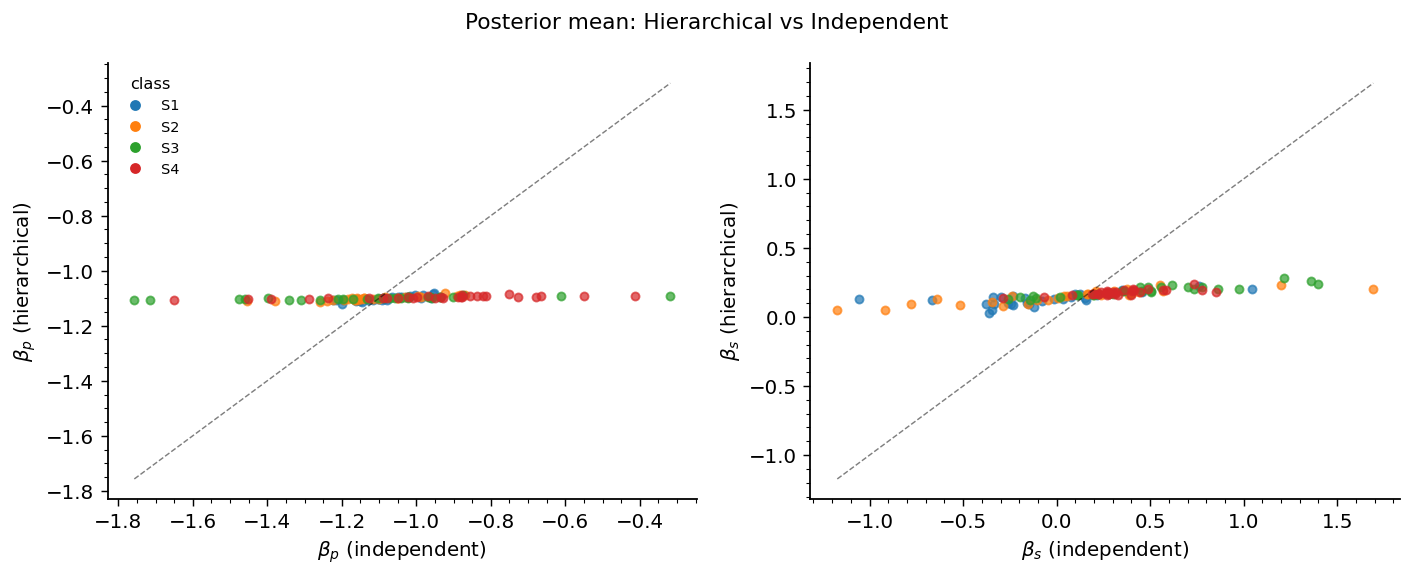

In [26]:
# ---- sigma(beta_p): independent vs hierarchical, both leverages ----
for N0 in sorted(df_comp['N'].unique()):
    sub = df_comp[df_comp['N'] == N0]
    if len(sub) < 3:
        continue
    fig, axes = plt.subplots(2, 2, figsize=(11, 9))
    fig.suptitle(rf'$N={N0}$: Independent vs Hierarchical uncertainty', fontsize=13)
    labels = sub['class_label'].to_numpy(str)

    # Row 0: sigma(beta_p) vs L_mass, L_stellar
    scatter_fits(axes[0,0], sub['L_mass'].values, sub['beta_p_sd'].values,
                 labels, r'$\sigma_{\beta_p}$ (indep)', r'$L_{\mathrm{mass}}$')
    scatter_fits(axes[0,1], sub['L_mass'].values, sub['hier_beta_p_sd'].values,
                 labels, r'$\sigma_{\beta_p}$ (hier)', r'$L_{\mathrm{mass}}$')

    # Row 1: sigma(beta_s) vs L_stellar
    scatter_fits(axes[1,0], sub['L_stellar'].values, sub['beta_s_sd'].values,
                 labels, r'$\sigma_{\beta_s}$ (indep)', r'$L_{\mathrm{stellar}}$')
    scatter_fits(axes[1,1], sub['L_stellar'].values, sub['hier_beta_s_sd'].values,
                 labels, r'$\sigma_{\beta_s}$ (hier)', r'$L_{\mathrm{stellar}}$')
    add_legend(axes[0,0], sub)
    fig.tight_layout()
    plt.show()

# ---- Shrinkage vs leverage ----
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle('Shrinkage weight vs Leverage (0 = fully pooled, 1 = data dominates)', fontsize=12)
labels = df_comp['class_label'].to_numpy(str)
for ax, Lcol, Llab, param in [
    (axes[0], 'L_mass',    r'$L_{\mathrm{mass}}$',    'shrinkage_beta_p'),
    (axes[1], 'L_stellar', r'$L_{\mathrm{stellar}}$', 'shrinkage_beta_s'),
]:
    for cls in CLS_ORD:
        cm = labels == cls
        if not cm.any():
            continue
        ax.scatter(df_comp.loc[cm, Lcol], df_comp.loc[cm, param],
                   s=20, alpha=0.7, color=CLS_CLR.get(cls,'k'), label=cls)
    ax.axhline(0.5, color='grey', ls='--', lw=0.8)
    ax.set_xlabel(Llab)
    pname = param.replace('shrinkage_', '')
    ax.set_ylabel(f'Shrinkage weight ({pname})')
    ax.set_ylim(-0.05, 1.05)
    ax.minorticks_on()
add_legend(axes[0], df_comp)
fig.tight_layout()
plt.show()

# ---- Posterior mean shift: hier vs indep ----
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle('Posterior mean: Hierarchical vs Independent', fontsize=12)
for ax, param, label in [
    (axes[0], 'beta_p', r'$\beta_p$'),
    (axes[1], 'beta_s', r'$\beta_s$'),
]:
    indep_vals = df_comp[f'{param}_mean'].values
    hier_vals  = df_comp[f'hier_{param}_mean'].values
    lims = [min(indep_vals.min(), hier_vals.min()), max(indep_vals.max(), hier_vals.max())]
    ax.plot(lims, lims, 'k--', lw=0.8, alpha=0.5)
    labs = df_comp['class_label'].to_numpy(str)
    for cls in CLS_ORD:
        cm = labs == cls
        if not cm.any():
            continue
        ax.scatter(indep_vals[cm], hier_vals[cm], s=20, alpha=0.7,
                   color=CLS_CLR.get(cls,'k'), label=cls)
    ax.set_xlabel(f'{label} (independent)')
    ax.set_ylabel(f'{label} (hierarchical)')
    ax.minorticks_on()
add_legend(axes[0], df_comp)
fig.tight_layout()
plt.show()